In [1]:
from __future__ import print_function
import numpy as np
import tensorflow as tf
from six.moves import cPickle as pickle
from six.moves import range
from sklearn.metrics import classification_report, confusion_matrix
#import confusion_matrix

pickle_file = 'SVHN_multi.pickle'

with open(pickle_file, 'rb') as f:
  save = pickle.load(f)
  train_dataset = save['train_dataset']
  train_labels = save['train_labels']
  valid_dataset = save['valid_dataset']
  valid_labels = save['valid_labels']
  test_dataset = save['test_dataset']
  test_labels = save['test_labels']
  del save  # hint to help gc free up memory
  print('Training set', train_dataset.shape, train_labels.shape)
  print('Validation set', valid_dataset.shape, valid_labels.shape)
  print('Test set', test_dataset.shape, test_labels.shape)

Training set (230070, 32, 32, 1) (230070, 6)
Validation set (5684, 32, 32, 1) (5684, 6)
Test set (13068, 32, 32, 1) (13068, 6)


In [2]:
def LecunLCN(X, image_shape, threshold=1e-4, radius=7, use_divisor=True):
    """Local Contrast Normalization"""
    """[http://yann.lecun.com/exdb/publis/pdf/jarrett-iccv-09.pdf]"""

    # Get Gaussian filter
    filter_shape = (radius, radius, image_shape[3], 1)

    #self.filters = theano.shared(self.gaussian_filter(filter_shape), borrow=True)
    filters = gaussian_filter(filter_shape)
    X = tf.convert_to_tensor(X, dtype=tf.float32)
    # Compute the Guassian weighted average by means of convolution
    convout = tf.nn.conv2d(X, filters, [1,1,1,1], 'SAME')

    # Subtractive step
    mid = int(np.floor(filter_shape[1] / 2.))

    # Make filter dimension broadcastable and subtract
    centered_X = tf.sub(X, convout)

    # Boolean marks whether or not to perform divisive step
    if use_divisor:
        # Note that the local variances can be computed by using the centered_X
        # tensor. If we convolve this with the mean filter, that should give us
        # the variance at each point. We simply take the square root to get our
        # denominator

        # Compute variances
        sum_sqr_XX = tf.nn.conv2d(tf.square(centered_X), filters, [1,1,1,1], 'SAME')

        # Take square root to get local standard deviation
        denom = tf.sqrt(sum_sqr_XX)

        per_img_mean = tf.reduce_mean(denom)
        divisor = tf.maximum(per_img_mean, denom)
        # Divisise step
        new_X = tf.truediv(centered_X, tf.maximum(divisor, threshold))
    else:
        new_X = centered_X

    return new_X


def gaussian_filter(kernel_shape):
    x = np.zeros(kernel_shape, dtype = float)
    mid = np.floor(kernel_shape[0] / 2.)
    
    for kernel_idx in xrange(0, kernel_shape[2]):
        for i in xrange(0, kernel_shape[0]):
            for j in xrange(0, kernel_shape[1]):
                x[i, j, kernel_idx, 0] = gauss(i - mid, j - mid)
    
    return tf.convert_to_tensor(x / np.sum(x), dtype=tf.float32)

def gauss(x, y, sigma=3.0):
    Z = 2 * np.pi * sigma ** 2
    return  1. / Z * np.exp(-(x ** 2 + y ** 2) / (2. * sigma ** 2))

In [3]:
def accuracy(predictions, labels):

  return (100.0 * np.sum(np.argmax(predictions, 2).T == labels) / predictions.shape[1] / predictions.shape[0])
# def accuracy(predictions, labels):

#   return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))/predictions.shape[0])

#### test for  measuring performance according to differennt dropout prababilities 

#### CONVOLUTION NEURAL NETWORK TEST  1: (1) dropout probability : 0.9375   (2) bias variable(tf.constant value): 1.0

In [7]:
#step-wise train. validation,test accuracy results are saved to forcsv1.csv file
with tf.device('/gpu:0'):
#with tf.device('/cpu:0'):    
    
            ##Variables.
   
    image_size = 32
    num_labels = 11 # blank, 0 ~ 9  
    num_channels = 1 # grayscale
    batch_size = 64
    patch_size = 5
    depth1 = 16
    depth2 = 32
    depth3 = 64
    num_hidden1 = 64
        #num_hidden2 = 16
    shape=[batch_size, image_size, image_size, num_channels]
        #keep_prob = 0.9375
        #keep_prob = 0.5
    
    
    
    graph = tf.Graph()
    with graph.as_default():


# Construct a 7-layer CNN after Local Contrast Normalization and gaussian filtering
# convolutional layer, batch_size x 28 x 28 x 16
# sub-sampling(hidden) layer, batch_size x 14 x 14 x 16 and max pooling
# convolutional layer, batch_size x 10 x 10 x 32
# sub-sampling (hidden) layer, batch_size x 10x 10 x 32 and max pooling
# convolutional layer, batch_size x 1 x 1 x 64
# hidden layer , batch_size x 1 x 1 x 64
# Dropout batch_size x 1 x 1 x 64
# fully-connected layer, weight size: batch_size x 11(blank, 0 ~9)
# Output: weight size: 64x 11(blank, 0 ~9)   

        
        def weight_variable(shape):
            initial = tf.truncated_normal(shape, stddev=0.1) #stddev change to 0.01 from 0.1
            return tf.Variable(initial)
                        
        def bias_variable(shape):
            #initial = tf.constant(0.0, shape=shape)
            initial = tf.constant(1.0, shape=shape)
            return tf.Variable(initial)
        
        def conv2d(data, weight):
            #return tf.nn.conv2d(data, weight, strides=[1,1,1,1], padding='SAME')
            return tf.nn.conv2d(data, weight, strides=[1,1,1,1], padding='VALID')
                   
        def relu2d(initial, bias):
            return tf.nn.relu(initial + bias) 
        
        def max_pool_2x2(x):
            return tf.nn.max_pool(x, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')
        
        def reshape_flat(initial, shape):
            return tf.reshape(initial, [shape[0], shape[1] * shape[2] * shape[3]])
        
        
        def dropout2d(initial, keep_prob):
            return tf.nn.dropout(initial, keep_prob)
        
#         def softmax2d(initial, bias):
#             return tf.nn.softmax(initial + bias)
        print ("image_size:",image_size)    
        #input data for  the training data, We use placeholder that will be fed
        #at run time with a trainig minibatch                  
        #shape = (64,32,32,1)
        tf_train_dataset = tf.placeholder(tf.float32, shape =(batch_size, image_size, image_size, num_channels))
        #tf_train_labels = tf.placeholder(tf.float32, shape = (batch_size, num_labels))
        tf_train_labels = tf.placeholder(tf.int32, shape=(batch_size, 6))  #(64,6)
        #tf_train_labels = tf.placeholder(tf.int64, shape=(batch_size))
        #tf_valid_dataset = tf.constant(mnist.validation.images.reshape(-1, 28, 28, 1))
        tf_valid_dataset = tf.constant(valid_dataset)
        #tf_test_dataset = tf.constant(mnist.test.images.reshape(-1, 28, 28, 1))
        tf_test_dataset = tf.constant(test_dataset)

#         #                                     32]
        weight_conv1 = weight_variable([5,5,1,16]) #[patch_size, patch_size, num_channels, depth1]
        bias_conv1 = bias_variable([16])   # [depth1] USED BE 32
        weight_conv2 = weight_variable([5,5,16,32])  #[patch_size, patch_size, depth1, depth2] USED  BE 32,65]
        bias_conv2 = bias_variable([32]) #[depth2]  
        weight_conv3 = weight_variable([5,5,32,64])  #[patch_size, patch_size, depth2, num_hidden1]
        bias_conv3 = bias_variable([64]) #[num_hidden1]

        
        w1 = weight_variable([64,11]) #[num_hidden1, num_labels]
        b1 = bias_variable([11]) #[num_labels]
        w2 = weight_variable([64,11]) #[num_hidden1, num_labels]
        b2 = bias_variable([11]) #[num_labels]
        w3 = weight_variable([64,11]) #[num_hidden1, num_labels]
        b3 = bias_variable([11]) #[num_labels]
        w4 = weight_variable([64,11]) #[num_hidden1, num_labels]
        b4 = bias_variable([11]) #[num_labels]
        w5 = weight_variable([64,11]) #[num_hidden1, num_labels]
        b5 = bias_variable([11]) #[num_labels]
        
        #def model(data, keep_prob, shape):
        def model(data, keep_prob,shape):
            lcn = LecunLCN(data, shape)
            
            print("lcn",lcn)
            conv = conv2d(lcn, weight_conv1)
            print("conv:",conv)
            hidden = relu2d(conv, bias_conv1)
            lrn = tf.nn.local_response_normalization(hidden) # little  impact on perfomance: can be deleted.
            pool = max_pool_2x2(lrn)
           
            print("pool1",pool)
            conv = conv2d(pool, weight_conv2)
            print("conv2:",conv)
            hidden = relu2d(conv, bias_conv2)

            print("hidden2:",hidden)
            pool = max_pool_2x2(hidden)
            #added conv layer (two lines)
            conv = conv2d(pool, weight_conv3)
            print("conv3",conv)
            hidden = relu2d(conv, bias_conv3)
            print("hidden3",hidden)
            ##added drop layer  
            drop = dropout2d(hidden,keep_prob)
            print("drop:",drop)
            ## original asf ##
            #shape = hidden.get_shape().as_list() 
            shape = drop.get_shape().as_list() 
            print("shape:",shape)
            #flat = reshape_flat(pool,shape)  # use when added conv layer is not deployed.  
            flat = reshape_flat(hidden,shape)
            print("flat:",flat)
            
            logits1 = tf.matmul(flat, w1)+b1
            
            logits2 = tf.matmul(flat, w2)+b2
            logits3 = tf.matmul(flat, w3)+b3
            logits4 = tf.matmul(flat, w4)+b4
            logits5 = tf.matmul(flat, w5)+b5
            return [logits1, logits2, logits3, logits4, logits5]
        

        # Training computation for continuous multiple  image as input data
        #dropout ratio is 0.9375
        [logits1, logits2, logits3, logits4, logits5] = model(tf_train_dataset, 0.9375, shape)#keep_prob=0.9375
        #[logits1, logits2, logits3, logits4, logits5] = model(tf_train_dataset, 0.5, shape)#keep_prob=0.5
        loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits1, tf_train_labels[:,1])) +\
        tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits2, tf_train_labels[:,2])) +\
        tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits3, tf_train_labels[:,3])) +\
        tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits4, tf_train_labels[:,4])) +\
        tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits5, tf_train_labels[:,5]))
    
        # Optimizer.
        #optimizer = tf.train.AdagradOptimizer(0.01).minimize(loss)
        global_step = tf.Variable(0)
        learning_rate = tf.train.exponential_decay(0.05, global_step, 10000, 0.95)
        optimizer = tf.train.AdagradOptimizer(learning_rate).minimize(loss, global_step=global_step)
  
        # Predictions for the training, validation, and test data.
        train_prediction = tf.pack([tf.nn.softmax(model(tf_train_dataset, 1.0, shape)[0]),\
                      tf.nn.softmax(model(tf_train_dataset, 1.0, shape)[1]),\
                      tf.nn.softmax(model(tf_train_dataset, 1.0, shape)[2]),\
                      tf.nn.softmax(model(tf_train_dataset, 1.0, shape)[3]),\
                      tf.nn.softmax(model(tf_train_dataset, 1.0, shape)[4])])
        valid_prediction = tf.pack([tf.nn.softmax(model(tf_valid_dataset, 1.0, shape)[0]),\
                      tf.nn.softmax(model(tf_valid_dataset, 1.0, shape)[1]),\
                      tf.nn.softmax(model(tf_valid_dataset, 1.0, shape)[2]),\
                      tf.nn.softmax(model(tf_valid_dataset, 1.0, shape)[3]),\
                      tf.nn.softmax(model(tf_valid_dataset, 1.0, shape)[4])])
        test_prediction = tf.pack([tf.nn.softmax(model(tf_test_dataset, 1.0, shape)[0]),\
                     tf.nn.softmax(model(tf_test_dataset, 1.0, shape)[1]),\
                     tf.nn.softmax(model(tf_test_dataset, 1.0, shape)[2]),\
                     tf.nn.softmax(model(tf_test_dataset, 1.0, shape)[3]),\
                     tf.nn.softmax(model(tf_test_dataset, 1.0, shape)[4])])
    
        saver = tf.train.Saver()

num_steps = 100001

with tf.Session(graph=graph) as session:
  tf.initialize_all_variables().run()  
  #reader = tf.train.NewCheckpointReader("CNN_1.ckpt")
  reader = tf.train.NewCheckpointReader("/home/ys/tensorflow/tensorflow/examples/capstone_ex/CNN_1.ckpt")
  reader.get_variable_to_shape_map()
  #saver.restore(session, "CNN_1.ckpt")
  print("Model restored.")  

  print('Initialized')
  for step in range(num_steps):
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    batch_data = train_dataset[offset:(offset + batch_size), :, :, :]
    batch_labels = train_labels[offset:(offset + batch_size),:]
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    
    #if (step % 500 == 0 or step == 100001): 
    if (step % 500 == 0): 
        M_batch_accuracy = accuracy(predictions, batch_labels[:,1:6])
        #to convert back  from tensor  to numpy array: .eval()
        Validation_accuracy = accuracy(valid_prediction.eval(), valid_labels[:,1:6])
        Test_accuracy = accuracy(test_prediction.eval(), test_labels[:,1:6])
            
        result5 = "{},{},{},{},{}\n".format(step,l,M_batch_accuracy,Validation_accuracy,Test_accuracy)
        with open("forcsv1.csv", "a") as myfile:
                myfile.write(result5)  
  print('Test accuracy: %.1f%%' % accuracy(test_prediction.eval(), test_labels[:,1:6]))
  save_path = saver.save(session, "CNN_multi_tune1.ckpt")
  #save_path = saver.save(session, "/home/ys/tensorflow/tensorflow/examples/capston/CNN_multi.ckpt")  
  print("Model saved in file: %s" % save_path)

image_size: 32
lcn Tensor("truediv:0", shape=(64, 32, 32, 1), dtype=float32)
conv: Tensor("Conv2D_2:0", shape=(64, 28, 28, 16), dtype=float32)
pool1 Tensor("MaxPool:0", shape=(64, 14, 14, 16), dtype=float32)
conv2: Tensor("Conv2D_3:0", shape=(64, 10, 10, 32), dtype=float32)
hidden2: Tensor("Relu_1:0", shape=(64, 10, 10, 32), dtype=float32)
conv3 Tensor("Conv2D_4:0", shape=(64, 1, 1, 64), dtype=float32)
hidden3 Tensor("Relu_2:0", shape=(64, 1, 1, 64), dtype=float32)
drop: Tensor("dropout/mul:0", shape=(64, 1, 1, 64), dtype=float32)
shape: [64, 1, 1, 64]
flat: Tensor("Reshape:0", shape=(64, 64), dtype=float32)
lcn Tensor("truediv_1:0", shape=(64, 32, 32, 1), dtype=float32)
conv: Tensor("Conv2D_7:0", shape=(64, 28, 28, 16), dtype=float32)
pool1 Tensor("MaxPool_2:0", shape=(64, 14, 14, 16), dtype=float32)
conv2: Tensor("Conv2D_8:0", shape=(64, 10, 10, 32), dtype=float32)
hidden2: Tensor("Relu_4:0", shape=(64, 10, 10, 32), dtype=float32)
conv3 Tensor("Conv2D_9:0", shape=(64, 1, 1, 64), dtyp

In [17]:
#step-wise train. validation,test accuracy results are saved to forcsv.csv file
import pandas as pd
df_a = pd.read_csv("forcsv1.csv",names = ["step","loss","minibatch_accuracy","validation_accuracy","test_accuracy"])
df_a.index.name='index_num'
print("(1) dropout probability : ","0.9753")
print("(2) bias variable(tf.constant value): ","1.0")
df_a.head()

(1) dropout probability :  0.9753
(2) bias variable(tf.constant value):  1.0


,step,loss,minibatch_accuracy,validation_accuracy,test_accuracy
index_num,,,,,
0,0,19.341871,6.8750,57.026742,63.665442
1,500,6.612533,57.5000,57.269529,63.905724
2,1000,6.661861,55.3125,57.470091,64.153658
3,1500,6.546460,56.2500,57.266010,63.899602
4,2000,6.594761,56.2500,57.470091,64.153658


In [18]:
df_a[196:201]

,step,loss,minibatch_accuracy,validation_accuracy,test_accuracy
index_num,,,,,
196,98000,6.959028,52.1875,57.470091,64.153658
197,98500,7.276660,51.5625,57.470091,64.153658
198,99000,6.812846,54.3750,57.470091,64.153658
199,99500,7.096985,53.1250,57.470091,64.153658
200,100000,6.692398,57.1875,57.470091,64.153658


(1) dropout probability :  0.9375
(2) bias variable(tf.constant value):  1.0


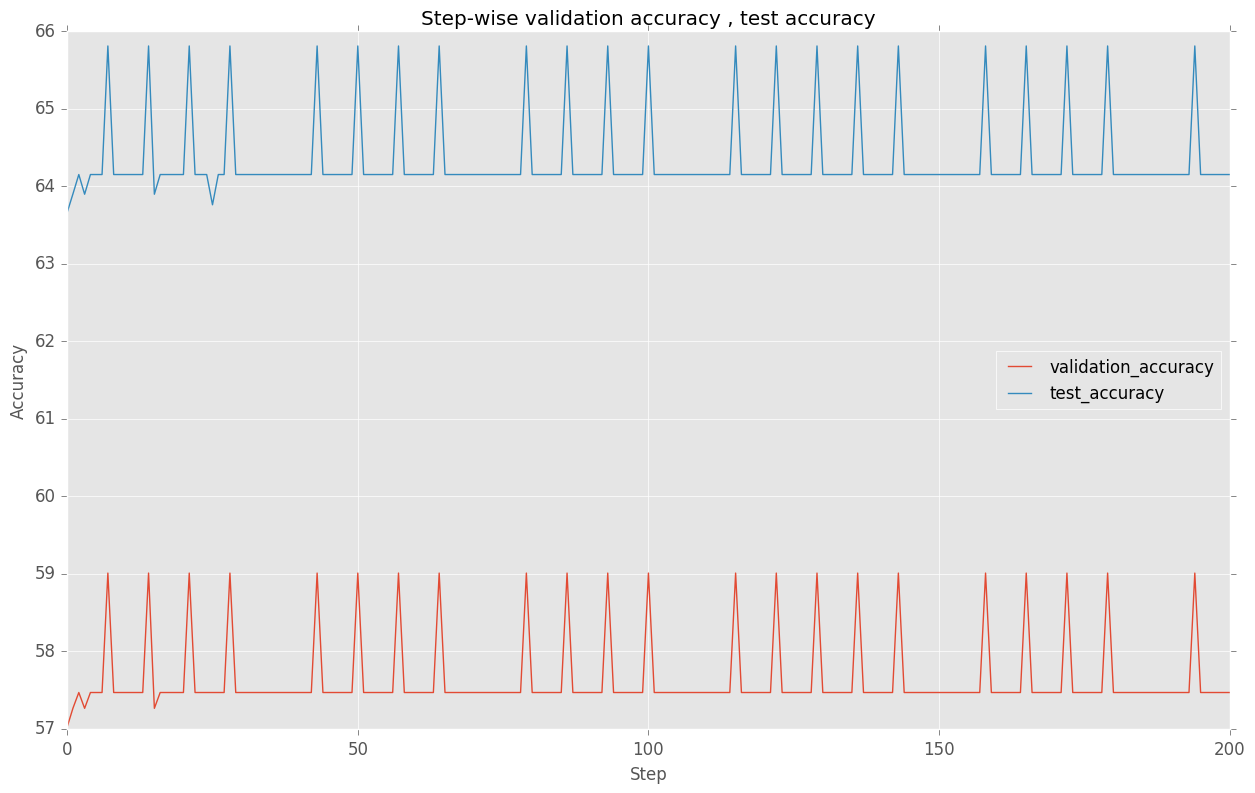

In [19]:
import numpy as np
#import renders as rs
from IPython.display import display 
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')
%matplotlib inline
print("(1) dropout probability : ","0.9375")
print("(2) bias variable(tf.constant value): ","1.0")
df_a1=pd.DataFrame(df_a,columns=["validation_accuracy","test_accuracy"])
ax = df_a1.plot(title="Step-wise validation accuracy , test accuracy",figsize=(15,9),legend=True, fontsize=12,stacked=False)
ax.set_xlabel("Step",fontsize=12)
ax.set_ylabel("Accuracy",fontsize=12)
plt.show()

(1) dropout probability :  0.9375
(2) bias variable(tf.constant value):  1.0


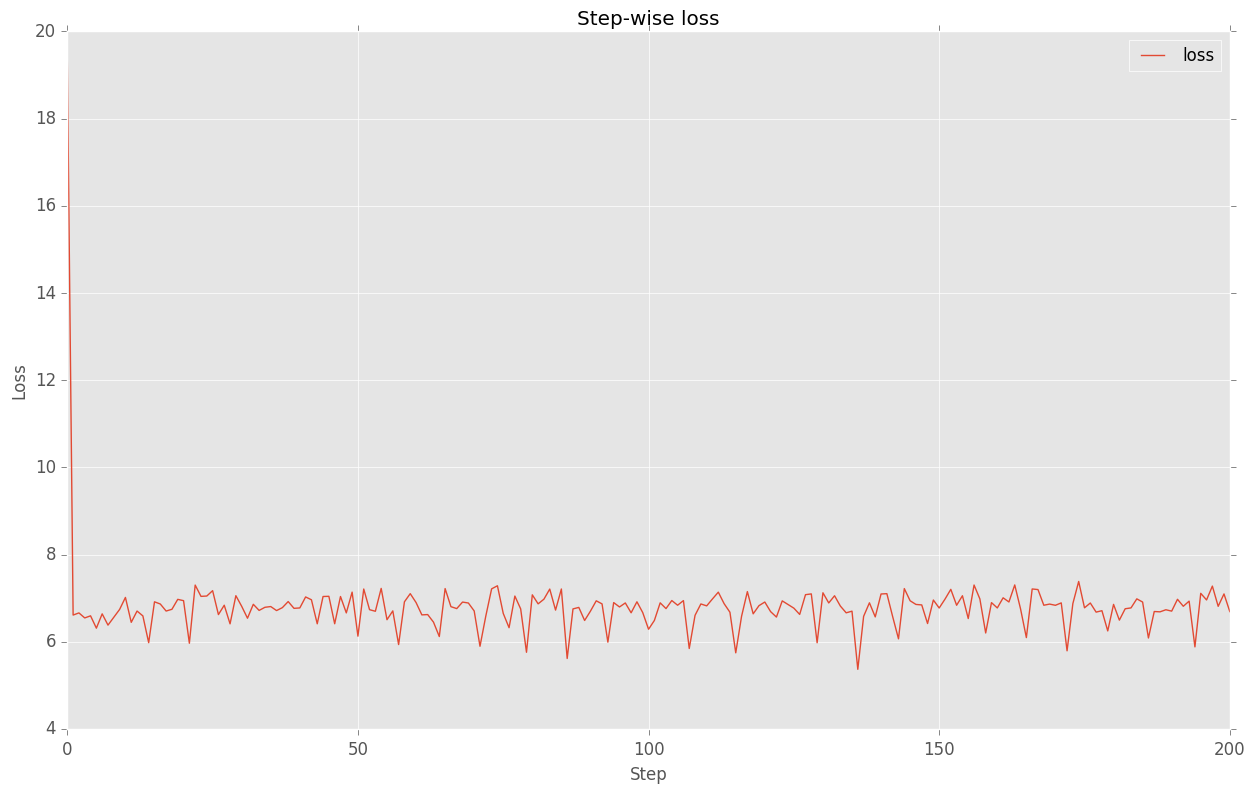

In [20]:
print("(1) dropout probability : ","0.9375")
print("(2) bias variable(tf.constant value): ","1.0")
df_a2=pd.DataFrame(df_a,columns=["loss"])
ax = df_a2.plot(title="Step-wise loss",figsize=(15,9),legend=True, fontsize=12,stacked=False)
ax.set_xlabel("Step",fontsize=12)
ax.set_ylabel("Loss",fontsize=12)
plt.show()

#### CONVOLUTION NEURAL NETWORK TEST 2 : (1) dropout probability : 0.5   (2) bias variable(tf.constant value): 1.0

In [14]:
#step-wise train. validation,test accuracy results are saved to forcsv2.csv file
with tf.device('/gpu:0'):
#with tf.device('/cpu:0'):    
    
            ##Variables.
   
    image_size = 32
    num_labels = 11 # blank, 0 ~ 9  
    num_channels = 1 # grayscale
    batch_size = 64
    patch_size = 5
    depth1 = 16
    depth2 = 32
    depth3 = 64
    num_hidden1 = 64
        #num_hidden2 = 16
    shape=[batch_size, image_size, image_size, num_channels]
        #keep_prob = 0.9375
        #keep_prob = 0.5
    
    
    
    graph = tf.Graph()
    with graph.as_default():


# Construct a 7-layer CNN.
# convolutional layer, batch_size x 28 x 28 x 16, convolution size: 5 x 5 x 1 x 16
# sub-sampling layer, batch_size x 14 x 14 x 16
# convolutional layer, batch_size x 10 x 10 x 32, convolution size: 5 x 5 x 16 x 32
# sub-sampling layer, batch_size x 5 x 5 x 32
# convolutional layer, batch_size x 1 x 1 x 64, convolution size: 5 x 5 x 32 x 64
# Dropout
# fully-connected layer, weight size: 64 x 16
# Output layer, weight size: 16 x 10     

        
        def weight_variable(shape):
            initial = tf.truncated_normal(shape, stddev=0.1) #stddev change to 0.01 from 0.1
            return tf.Variable(initial)
                        
        def bias_variable(shape):
            #initial = tf.constant(0.0, shape=shape)
            initial = tf.constant(1.0, shape=shape)
            return tf.Variable(initial)
        
        def conv2d(data, weight):
            #return tf.nn.conv2d(data, weight, strides=[1,1,1,1], padding='SAME')
            return tf.nn.conv2d(data, weight, strides=[1,1,1,1], padding='VALID')
                   
        def relu2d(initial, bias):
            return tf.nn.relu(initial + bias) 
        
        def max_pool_2x2(x):
            return tf.nn.max_pool(x, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')
        
        def reshape_flat(initial, shape):
            return tf.reshape(initial, [shape[0], shape[1] * shape[2] * shape[3]])
        
        
        def dropout2d(initial, keep_prob):
            return tf.nn.dropout(initial, keep_prob)
        
#         def softmax2d(initial, bias):
#             return tf.nn.softmax(initial + bias)
        print ("image_size:",image_size)    
        #input data for  the training data, We use placeholder that will be fed
        #at run time with a trainig minibatch                  
        #shape = (64,32,32,1)
        tf_train_dataset = tf.placeholder(tf.float32, shape =(batch_size, image_size, image_size, num_channels))
        #tf_train_labels = tf.placeholder(tf.float32, shape = (batch_size, num_labels))
        tf_train_labels = tf.placeholder(tf.int32, shape=(batch_size, 6))  #(64,6)
        #tf_train_labels = tf.placeholder(tf.int64, shape=(batch_size))
        #tf_valid_dataset = tf.constant(mnist.validation.images.reshape(-1, 28, 28, 1))
        tf_valid_dataset = tf.constant(valid_dataset)
        #tf_test_dataset = tf.constant(mnist.test.images.reshape(-1, 28, 28, 1))
        tf_test_dataset = tf.constant(test_dataset)

#         #                                     32]
        weight_conv1 = weight_variable([5,5,1,16]) #[patch_size, patch_size, num_channels, depth1]
        bias_conv1 = bias_variable([16])   # [depth1] USED BE 32
        weight_conv2 = weight_variable([5,5,16,32])  #[patch_size, patch_size, depth1, depth2] USED  BE 32,65]
        bias_conv2 = bias_variable([32]) #[depth2]  
        weight_conv3 = weight_variable([5,5,32,64])  #[patch_size, patch_size, depth2, num_hidden1]
        bias_conv3 = bias_variable([64]) #[num_hidden1]

        
        w1 = weight_variable([64,11]) #[num_hidden1, num_labels]
        b1 = bias_variable([11]) #[num_labels]
        w2 = weight_variable([64,11]) #[num_hidden1, num_labels]
        b2 = bias_variable([11]) #[num_labels]
        w3 = weight_variable([64,11]) #[num_hidden1, num_labels]
        b3 = bias_variable([11]) #[num_labels]
        w4 = weight_variable([64,11]) #[num_hidden1, num_labels]
        b4 = bias_variable([11]) #[num_labels]
        w5 = weight_variable([64,11]) #[num_hidden1, num_labels]
        b5 = bias_variable([11]) #[num_labels]
        
        #def model(data, keep_prob, shape):
        def model(data, keep_prob,shape):
            lcn = LecunLCN(data, shape)
            
            print("lcn",lcn)
            conv = conv2d(lcn, weight_conv1)
            print("conv:",conv)
            hidden = relu2d(conv, bias_conv1)
            lrn = tf.nn.local_response_normalization(hidden) # little  impact on perfomance: can be deleted.
            pool = max_pool_2x2(lrn)
            
            print("pool1",pool)
            conv = conv2d(pool, weight_conv2)
            print("conv2:",conv)
            hidden = relu2d(conv, bias_conv2)

            print("hidden2:",hidden)
            pool = max_pool_2x2(hidden)
            #added conv layer (two lines)
            conv = conv2d(pool, weight_conv3)
            print("conv3",conv)
            hidden = relu2d(conv, bias_conv3)
            print("hidden3",hidden)
            ##added drop layer  
            drop = dropout2d(hidden,keep_prob)
            print("drop:",drop)
            ## original asf ##
            #shape = hidden.get_shape().as_list() 
            shape = drop.get_shape().as_list() 
            print("shape:",shape)
            #flat = reshape_flat(pool,shape)  # use when added conv layer is not deployed.  
            flat = reshape_flat(hidden,shape)
            print("flat:",flat)
            
            logits1 = tf.matmul(flat, w1)+b1
            logits2 = tf.matmul(flat, w2)+b2
            logits3 = tf.matmul(flat, w3)+b3
            logits4 = tf.matmul(flat, w4)+b4
            logits5 = tf.matmul(flat, w5)+b5
            return [logits1, logits2, logits3, logits4, logits5]
        
 
       # Training computation.
        #[logits1, logits2, logits3, logits4, logits5] = model(tf_train_dataset, 0.9375, shape)
        [logits1, logits2, logits3, logits4, logits5] = model(tf_train_dataset, 0.5, shape)
        loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits1, tf_train_labels[:,1])) +\
        tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits2, tf_train_labels[:,2])) +\
        tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits3, tf_train_labels[:,3])) +\
        tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits4, tf_train_labels[:,4])) +\
        tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits5, tf_train_labels[:,5]))
    
        # Optimizer.
        #optimizer = tf.train.AdagradOptimizer(0.01).minimize(loss)
        global_step = tf.Variable(0)
        learning_rate = tf.train.exponential_decay(0.05, global_step, 10000, 0.95)
        optimizer = tf.train.AdagradOptimizer(learning_rate).minimize(loss, global_step=global_step)
  
        # Predictions for the training, validation, and test data.
        train_prediction = tf.pack([tf.nn.softmax(model(tf_train_dataset, 1.0, shape)[0]),\
                      tf.nn.softmax(model(tf_train_dataset, 1.0, shape)[1]),\
                      tf.nn.softmax(model(tf_train_dataset, 1.0, shape)[2]),\
                      tf.nn.softmax(model(tf_train_dataset, 1.0, shape)[3]),\
                      tf.nn.softmax(model(tf_train_dataset, 1.0, shape)[4])])
        valid_prediction = tf.pack([tf.nn.softmax(model(tf_valid_dataset, 1.0, shape)[0]),\
                      tf.nn.softmax(model(tf_valid_dataset, 1.0, shape)[1]),\
                      tf.nn.softmax(model(tf_valid_dataset, 1.0, shape)[2]),\
                      tf.nn.softmax(model(tf_valid_dataset, 1.0, shape)[3]),\
                      tf.nn.softmax(model(tf_valid_dataset, 1.0, shape)[4])])
        test_prediction = tf.pack([tf.nn.softmax(model(tf_test_dataset, 1.0, shape)[0]),\
                     tf.nn.softmax(model(tf_test_dataset, 1.0, shape)[1]),\
                     tf.nn.softmax(model(tf_test_dataset, 1.0, shape)[2]),\
                     tf.nn.softmax(model(tf_test_dataset, 1.0, shape)[3]),\
                     tf.nn.softmax(model(tf_test_dataset, 1.0, shape)[4])])
    
        saver = tf.train.Saver()

num_steps = 100001

with tf.Session(graph=graph) as session:
  tf.initialize_all_variables().run()  
  #reader = tf.train.NewCheckpointReader("CNN_1.ckpt")
  reader = tf.train.NewCheckpointReader("/home/ys/tensorflow/tensorflow/examples/capstone_ex/CNN_1.ckpt")
  reader.get_variable_to_shape_map()
  #saver.restore(session, "CNN_1.ckpt")
  print("Model restored.")  

  print('Initialized')
  for step in range(num_steps):
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    batch_data = train_dataset[offset:(offset + batch_size), :, :, :]
    batch_labels = train_labels[offset:(offset + batch_size),:]
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    
    #if (step % 500 == 0 or step == 100001): 
    if (step % 500 == 0): 
        M_batch_accuracy = accuracy(predictions, batch_labels[:,1:6])
        Validation_accuracy = accuracy(valid_prediction.eval(), valid_labels[:,1:6])
        Test_accuracy = accuracy(test_prediction.eval(), test_labels[:,1:6])
            
        result5 = "{},{},{},{},{}\n".format(step,l,M_batch_accuracy,Validation_accuracy,Test_accuracy)
        with open("forcsv2.csv", "a") as myfile:
                myfile.write(result5)  
  print('Test accuracy: %.1f%%' % accuracy(test_prediction.eval(), test_labels[:,1:6]))
  print('Confusion Matrix of test data:\n', confusion_matrix(test_labels, test_prediction))
  save_path = saver.save(session, "CNN_multi_tune2.ckpt")
  #save_path = saver.save(session, "/home/ys/tensorflow/tensorflow/examples/capston/CNN_multi.ckpt")  
  print("Model saved in file: %s" % save_path)

image_size: 32
lcn Tensor("truediv:0", shape=(64, 32, 32, 1), dtype=float32)
conv: Tensor("Conv2D_2:0", shape=(64, 28, 28, 16), dtype=float32)
pool1 Tensor("MaxPool:0", shape=(64, 14, 14, 16), dtype=float32)
conv2: Tensor("Conv2D_3:0", shape=(64, 10, 10, 32), dtype=float32)
hidden2: Tensor("Relu_1:0", shape=(64, 10, 10, 32), dtype=float32)
conv3 Tensor("Conv2D_4:0", shape=(64, 1, 1, 64), dtype=float32)
hidden3 Tensor("Relu_2:0", shape=(64, 1, 1, 64), dtype=float32)
drop: Tensor("dropout/mul:0", shape=(64, 1, 1, 64), dtype=float32)
shape: [64, 1, 1, 64]
flat: Tensor("Reshape:0", shape=(64, 64), dtype=float32)
lcn Tensor("truediv_1:0", shape=(64, 32, 32, 1), dtype=float32)
conv: Tensor("Conv2D_7:0", shape=(64, 28, 28, 16), dtype=float32)
pool1 Tensor("MaxPool_2:0", shape=(64, 14, 14, 16), dtype=float32)
conv2: Tensor("Conv2D_8:0", shape=(64, 10, 10, 32), dtype=float32)
hidden2: Tensor("Relu_4:0", shape=(64, 10, 10, 32), dtype=float32)
conv3 Tensor("Conv2D_9:0", shape=(64, 1, 1, 64), dtyp

In [15]:
#step-wise train. validation,test accuracy results are saved to forcsv.csv file
import pandas as pd
df_b = pd.read_csv("forcsv2.csv",names = ["step","loss","minibatch_accuracy","validation_accuracy","test_accuracy"])
df_b.index.name='index_num'
print("(1) dropout probability : ","0.5")
print("(2) bias variable(tf.constant value): ","1.0")
df_b.head()

(1) dropout probability :  0.5
(2) bias variable(tf.constant value):  1.0


,step,loss,minibatch_accuracy,validation_accuracy,test_accuracy
index_num,,,,,
0,0,18.124712,9.3750,43.764954,47.367616
1,500,6.709145,54.3750,57.470091,64.153658
2,1000,6.824737,53.1250,57.470091,63.763391
3,1500,7.346371,51.8750,57.470091,64.153658
4,2000,7.222589,52.1875,57.470091,64.153658


In [16]:
df[196:201]

,step,loss,minibatch_accuracy,validation_accuracy,test_accuracy
index_num,,,,,
196,98000,6.860184,55.6250,57.470091,64.153658
197,98500,6.681941,56.2500,57.470091,64.153658
198,99000,6.439458,59.6875,57.470091,64.153658
199,99500,6.882485,53.7500,57.470091,64.153658
200,100000,6.834931,55.0000,57.470091,64.153658


(1) dropout probability :  0.5
(2) bias variable(tf.constant value):  1.0


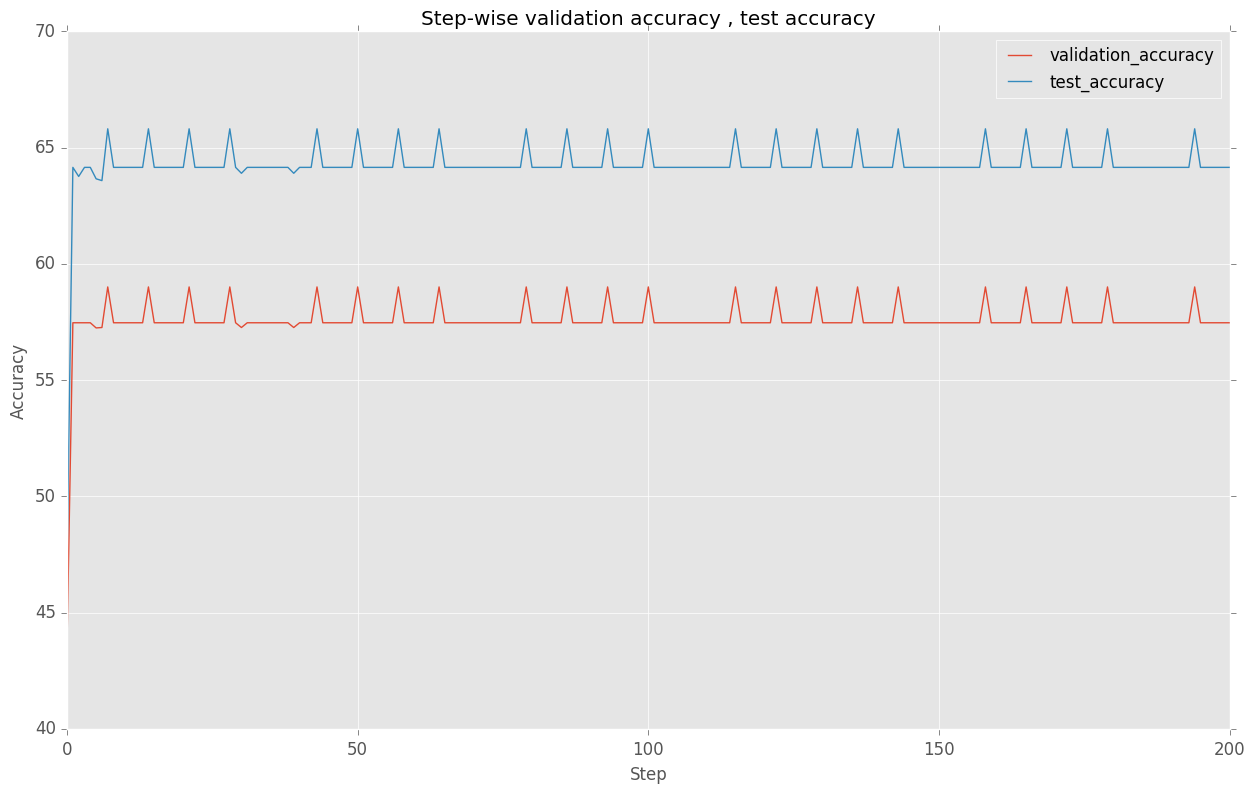

In [17]:
import numpy as np
#import renders as rs
from IPython.display import display 
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')
%matplotlib inline
print("(1) dropout probability : ","0.5")
print("(2) bias variable(tf.constant value): ","1.0")
df_b1=pd.DataFrame(df_b,columns=["validation_accuracy","test_accuracy"])
ax = df_b1.plot(title="Step-wise validation accuracy , test accuracy",figsize=(15,9),legend=True, fontsize=12,stacked=False)
ax.set_xlabel("Step",fontsize=12)
ax.set_ylabel("Accuracy",fontsize=12)
plt.show()

(1) dropout probability :  0.5
(2) bias variable(tf.constant value):  1.0


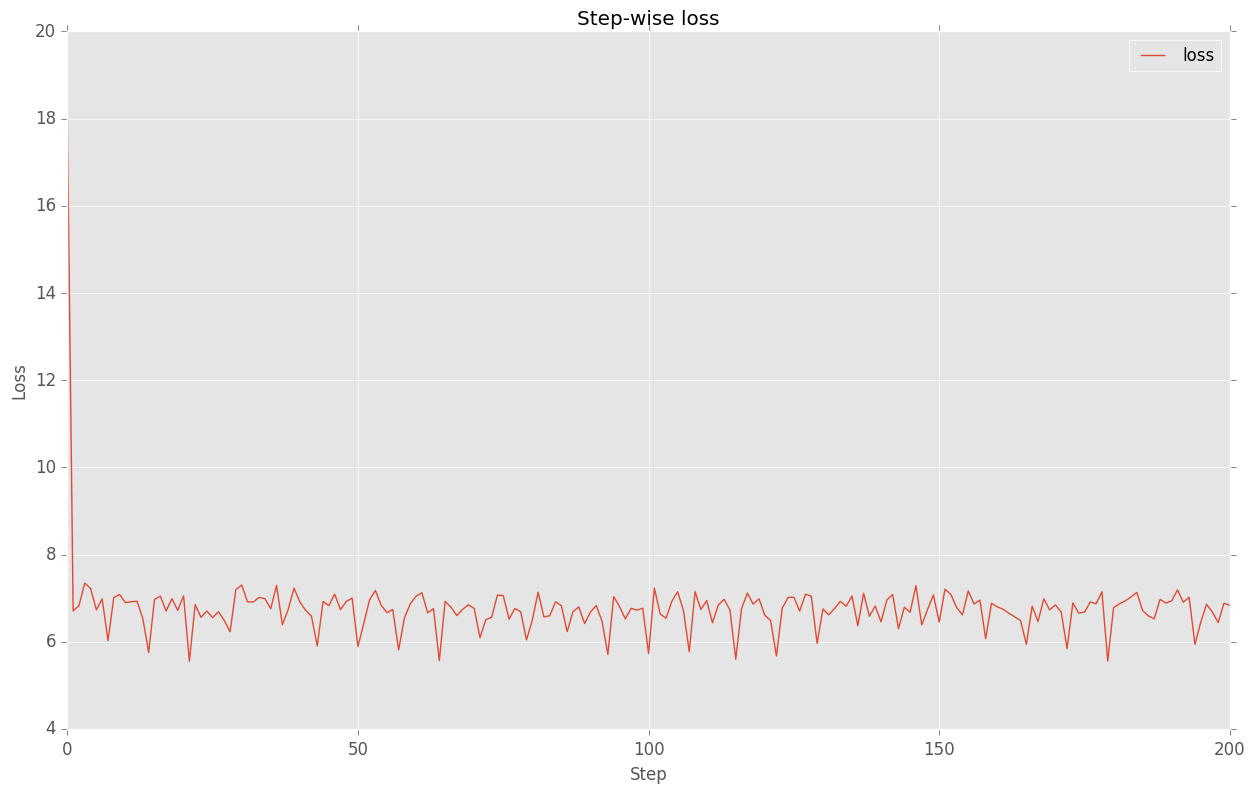

In [18]:
print("(1) dropout probability : ","0.5")
print("(2) bias variable(tf.constant value): ","1.0")
df_b2=pd.DataFrame(df_b,columns=["loss"])
ax = df_b2.plot(title="Step-wise loss",figsize=(15,9),legend=True, fontsize=12,stacked=False)
ax.set_xlabel("Step",fontsize=12)
ax.set_ylabel("Loss",fontsize=12)
plt.show()

#### CONVOLUTION NEURAL NETWORK TEST 3 : (1) dropout probability : 0.5   (2) bias variable(tf.constant value): 0.0

In [19]:
#step-wise train. validation,test accuracy results are saved to forcsv3.csv file
with tf.device('/gpu:0'):
#with tf.device('/cpu:0'):    
    
            ##Variables.
   
    image_size = 32
    num_labels = 11 # blank, 0 ~ 9  
    num_channels = 1 # grayscale
    batch_size = 64
    patch_size = 5
    depth1 = 16
    depth2 = 32
    depth3 = 64
    num_hidden1 = 64
        #num_hidden2 = 16
    shape=[batch_size, image_size, image_size, num_channels]
        #keep_prob = 0.9375
        #keep_prob = 0.5
    
    
    
    graph = tf.Graph()
    with graph.as_default():


# Construct a 7-layer CNN.
# convolutional layer, batch_size x 28 x 28 x 16, convolution size: 5 x 5 x 1 x 16
# sub-sampling layer, batch_size x 14 x 14 x 16
# convolutional layer, batch_size x 10 x 10 x 32, convolution size: 5 x 5 x 16 x 32
# sub-sampling layer, batch_size x 5 x 5 x 32
# convolutional layer, batch_size x 1 x 1 x 64, convolution size: 5 x 5 x 32 x 64
# Dropout
# fully-connected layer, weight size: 64 x 16
# Output layer, weight size: 16 x 10   

        
        def weight_variable(shape):
            initial = tf.truncated_normal(shape, stddev=0.1) #stddev change to 0.01 from 0.1
            return tf.Variable(initial)
                        
        def bias_variable(shape):
            initial = tf.constant(0.0, shape=shape)
            #initial = tf.constant(1.0, shape=shape)
            return tf.Variable(initial)
        
        def conv2d(data, weight):
            #return tf.nn.conv2d(data, weight, strides=[1,1,1,1], padding='SAME')
            return tf.nn.conv2d(data, weight, strides=[1,1,1,1], padding='VALID')
                   
        def relu2d(initial, bias):
            return tf.nn.relu(initial + bias) 
        
        def max_pool_2x2(x):
            return tf.nn.max_pool(x, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')
        
        def reshape_flat(initial, shape):
            return tf.reshape(initial, [shape[0], shape[1] * shape[2] * shape[3]])
        
        
        def dropout2d(initial, keep_prob):
            return tf.nn.dropout(initial, keep_prob)
        
#         def softmax2d(initial, bias):
#             return tf.nn.softmax(initial + bias)
        print ("image_size:",image_size)    
        #input data for  the training data, We use placeholder that will be fed
        #at run time with a trainig minibatch                  
        #shape = (64,32,32,1)
        tf_train_dataset = tf.placeholder(tf.float32, shape =(batch_size, image_size, image_size, num_channels))
        #tf_train_labels = tf.placeholder(tf.float32, shape = (batch_size, num_labels))
        tf_train_labels = tf.placeholder(tf.int32, shape=(batch_size, 6))  #(64,6)
        #tf_train_labels = tf.placeholder(tf.int64, shape=(batch_size))
        #tf_valid_dataset = tf.constant(mnist.validation.images.reshape(-1, 28, 28, 1))
        tf_valid_dataset = tf.constant(valid_dataset)
        #tf_test_dataset = tf.constant(mnist.test.images.reshape(-1, 28, 28, 1))
        tf_test_dataset = tf.constant(test_dataset)

#         #                                     32]
        weight_conv1 = weight_variable([5,5,1,16]) #[patch_size, patch_size, num_channels, depth1]
        bias_conv1 = bias_variable([16])   # [depth1] USED BE 32
        weight_conv2 = weight_variable([5,5,16,32])  #[patch_size, patch_size, depth1, depth2] USED  BE 32,65]
        bias_conv2 = bias_variable([32]) #[depth2]  
        weight_conv3 = weight_variable([5,5,32,64])  #[patch_size, patch_size, depth2, num_hidden1]
        bias_conv3 = bias_variable([64]) #[num_hidden1]

        
        w1 = weight_variable([64,11]) #[num_hidden1, num_labels]
        b1 = bias_variable([11]) #[num_labels]
        w2 = weight_variable([64,11]) #[num_hidden1, num_labels]
        b2 = bias_variable([11]) #[num_labels]
        w3 = weight_variable([64,11]) #[num_hidden1, num_labels]
        b3 = bias_variable([11]) #[num_labels]
        w4 = weight_variable([64,11]) #[num_hidden1, num_labels]
        b4 = bias_variable([11]) #[num_labels]
        w5 = weight_variable([64,11]) #[num_hidden1, num_labels]
        b5 = bias_variable([11]) #[num_labels]
        
        #def model(data, keep_prob, shape):
        def model(data, keep_prob,shape):
            lcn = LecunLCN(data, shape)
            
            print("lcn",lcn)
            conv = conv2d(lcn, weight_conv1)
            print("conv:",conv)
            hidden = relu2d(conv, bias_conv1)
            lrn = tf.nn.local_response_normalization(hidden) # little  impact on perfomance: can be deleted.
            pool = max_pool_2x2(lrn) 
            print("pool1",pool)
            conv = conv2d(pool, weight_conv2)
            print("conv2:",conv)
            hidden = relu2d(conv, bias_conv2)
            print("hidden2:",hidden)
            pool = max_pool_2x2(hidden)
            #added conv layer (two lines)
            conv = conv2d(pool, weight_conv3)
            print("conv3",conv)
            hidden = relu2d(conv, bias_conv3)
            print("hidden3",hidden)
            ##added drop layer  
            drop = dropout2d(hidden,keep_prob)
            print("drop:",drop)
            ## original asf ##
            #shape = hidden.get_shape().as_list() 
            shape = drop.get_shape().as_list() 
            print("shape:",shape)
            #flat = reshape_flat(pool,shape)  # use when added conv layer is not deployed.  
            flat = reshape_flat(hidden,shape)
            print("flat:",flat)
            
            logits1 = tf.matmul(flat, w1)+b1
            logits2 = tf.matmul(flat, w2)+b2
            logits3 = tf.matmul(flat, w3)+b3
            logits4 = tf.matmul(flat, w4)+b4
            logits5 = tf.matmul(flat, w5)+b5
            return [logits1, logits2, logits3, logits4, logits5]
        
 
       # Training computation.
        #[logits1, logits2, logits3, logits4, logits5] = model(tf_train_dataset, 0.9375, shape)
        [logits1, logits2, logits3, logits4, logits5] = model(tf_train_dataset, 0.5, shape)
        loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits1, tf_train_labels[:,1])) +\
        tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits2, tf_train_labels[:,2])) +\
        tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits3, tf_train_labels[:,3])) +\
        tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits4, tf_train_labels[:,4])) +\
        tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits5, tf_train_labels[:,5]))
    
        # Optimizer.
        #optimizer = tf.train.AdagradOptimizer(0.01).minimize(loss)
        global_step = tf.Variable(0)
        learning_rate = tf.train.exponential_decay(0.05, global_step, 10000, 0.95)
        optimizer = tf.train.AdagradOptimizer(learning_rate).minimize(loss, global_step=global_step)
  
        # Predictions for the training, validation, and test data.
        train_prediction = tf.pack([tf.nn.softmax(model(tf_train_dataset, 1.0, shape)[0]),\
                      tf.nn.softmax(model(tf_train_dataset, 1.0, shape)[1]),\
                      tf.nn.softmax(model(tf_train_dataset, 1.0, shape)[2]),\
                      tf.nn.softmax(model(tf_train_dataset, 1.0, shape)[3]),\
                      tf.nn.softmax(model(tf_train_dataset, 1.0, shape)[4])])
        valid_prediction = tf.pack([tf.nn.softmax(model(tf_valid_dataset, 1.0, shape)[0]),\
                      tf.nn.softmax(model(tf_valid_dataset, 1.0, shape)[1]),\
                      tf.nn.softmax(model(tf_valid_dataset, 1.0, shape)[2]),\
                      tf.nn.softmax(model(tf_valid_dataset, 1.0, shape)[3]),\
                      tf.nn.softmax(model(tf_valid_dataset, 1.0, shape)[4])])
        test_prediction = tf.pack([tf.nn.softmax(model(tf_test_dataset, 1.0, shape)[0]),\
                     tf.nn.softmax(model(tf_test_dataset, 1.0, shape)[1]),\
                     tf.nn.softmax(model(tf_test_dataset, 1.0, shape)[2]),\
                     tf.nn.softmax(model(tf_test_dataset, 1.0, shape)[3]),\
                     tf.nn.softmax(model(tf_test_dataset, 1.0, shape)[4])])
    
        saver = tf.train.Saver()

num_steps = 100001

with tf.Session(graph=graph) as session:
  tf.initialize_all_variables().run()  
  #reader = tf.train.NewCheckpointReader("CNN_1.ckpt")
  reader = tf.train.NewCheckpointReader("/home/ys/tensorflow/tensorflow/examples/capstone_ex/CNN_1.ckpt")
  reader.get_variable_to_shape_map()
  #saver.restore(session, "CNN_1.ckpt")
  print("Model restored.")  

  print('Initialized')
  for step in range(num_steps):
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    batch_data = train_dataset[offset:(offset + batch_size), :, :, :]
    batch_labels = train_labels[offset:(offset + batch_size),:]
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    
    #if (step % 500 == 0 or step == 100001): 
    if (step % 500 == 0): 
        M_batch_accuracy = accuracy(predictions, batch_labels[:,1:6])
        Validation_accuracy = accuracy(valid_prediction.eval(), valid_labels[:,1:6])
        Test_accuracy = accuracy(test_prediction.eval(), test_labels[:,1:6])
        #save step, loss, accuracy into csv file.    
        result5 = "{},{},{},{},{}\n".format(step,l,M_batch_accuracy,Validation_accuracy,Test_accuracy)
        with open("forcsv3.csv", "a") as myfile:
                myfile.write(result5)  
  print('Test accuracy: %.1f%%' % accuracy(test_prediction.eval(), test_labels[:,1:6]))
  print('Confusion Matrix of test data:\n', confusion_matrix(test_labels, test_prediction))
  save_path = saver.save(session, "CNN_multi_tune3.ckpt")
  #save_path = saver.save(session, "/home/ys/tensorflow/tensorflow/examples/capston/CNN_multi.ckpt")  
  print("Model saved in file: %s" % save_path)

image_size: 32
lcn Tensor("truediv:0", shape=(64, 32, 32, 1), dtype=float32)
conv: Tensor("Conv2D_2:0", shape=(64, 28, 28, 16), dtype=float32)
pool1 Tensor("MaxPool:0", shape=(64, 14, 14, 16), dtype=float32)
conv2: Tensor("Conv2D_3:0", shape=(64, 10, 10, 32), dtype=float32)
hidden2: Tensor("Relu_1:0", shape=(64, 10, 10, 32), dtype=float32)
conv3 Tensor("Conv2D_4:0", shape=(64, 1, 1, 64), dtype=float32)
hidden3 Tensor("Relu_2:0", shape=(64, 1, 1, 64), dtype=float32)
drop: Tensor("dropout/mul:0", shape=(64, 1, 1, 64), dtype=float32)
shape: [64, 1, 1, 64]
flat: Tensor("Reshape:0", shape=(64, 64), dtype=float32)
lcn Tensor("truediv_1:0", shape=(64, 32, 32, 1), dtype=float32)
conv: Tensor("Conv2D_7:0", shape=(64, 28, 28, 16), dtype=float32)
pool1 Tensor("MaxPool_2:0", shape=(64, 14, 14, 16), dtype=float32)
conv2: Tensor("Conv2D_8:0", shape=(64, 10, 10, 32), dtype=float32)
hidden2: Tensor("Relu_4:0", shape=(64, 10, 10, 32), dtype=float32)
conv3 Tensor("Conv2D_9:0", shape=(64, 1, 1, 64), dtyp

In [23]:
#step-wise train. validation,test accuracy results are saved to forcsv.csv file
import pandas as pd
df_c = pd.read_csv("forcsv3.csv",names = ["step","loss","minibatch_accuracy","validation_accuracy","test_accuracy"])
df_c.index.name='index_num'
print("(1) dropout probability : ","0.5")
print("(2) bias variable(tf.constant value): ","0.0")
df_c.head()

(1) dropout probability :  0.5
(2) bias variable(tf.constant value):  0.0


,step,loss,minibatch_accuracy,validation_accuracy,test_accuracy
index_num,,,,,
0,0,13.600397,4.3750,57.030260,60.492807
1,500,2.281906,87.1875,82.163969,83.677686
2,1000,1.846698,87.1875,86.755806,87.765534
3,1500,1.727024,90.6250,87.846587,88.980716
4,2000,1.205188,91.2500,89.123856,89.857668


In [25]:
df[196:201]

,step,loss,minibatch_accuracy,validation_accuracy,test_accuracy
index_num,,,,,
196,98000,0.800287,95.625,94.268121,94.426079
197,98500,0.331358,98.750,94.342013,94.415366
198,99000,0.306903,98.125,94.345531,94.436792
199,99500,0.300293,98.750,94.317382,94.418427
200,100000,0.647215,96.250,94.342013,94.449036


(1) dropout probability :  0.5
(2) bias variable(tf.constant value):  0.0


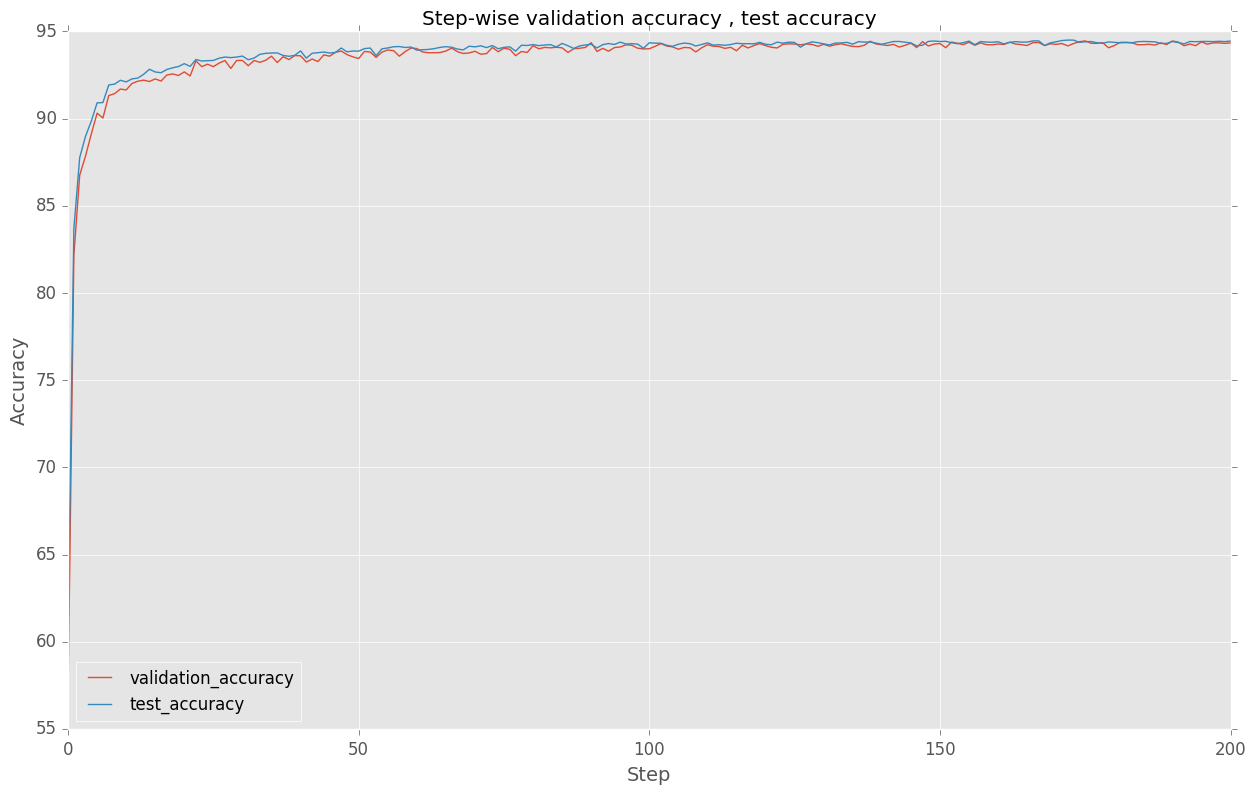

In [26]:

import numpy as np
#import renders as rs
from IPython.display import display 
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')
%matplotlib inline
print("(1) dropout probability : ","0.5")
print("(2) bias variable(tf.constant value): ","0.0")
df_c1=pd_c.DataFrame(df_c,columns=["validation_accuracy","test_accuracy"])
ax = df_c1.plot(title="Step-wise validation accuracy , test accuracy",figsize=(15,9),legend=True, fontsize=12,stacked=False)
ax.set_xlabel("Step",fontsize=14)
ax.set_ylabel("Accuracy",fontsize=14)
plt.show()

(1) dropout probability :  0.5
(2) bias variable(tf.constant value):  0.0


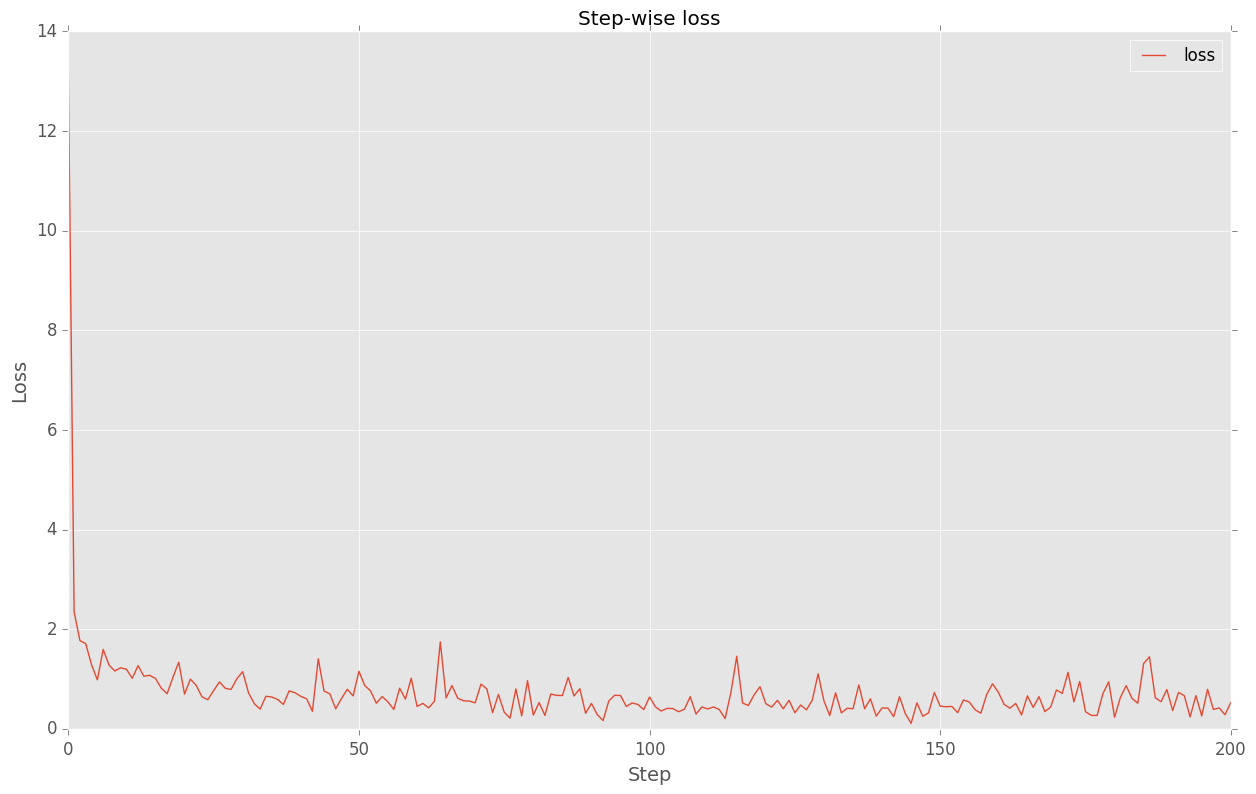

In [24]:
print("(1) dropout probability : ","0.5")
print("(2) bias variable(tf.constant value): ","0.0")
df_c2=pd.DataFrame(df_c,columns=["loss"])
ax = df_c2.plot(title="Step-wise loss",figsize=(15,9),legend=True, fontsize=12,stacked=False)
ax.set_xlabel("Step",fontsize=14)
ax.set_ylabel("Loss",fontsize=14)
plt.show()

#### CONVOLUTION NEURAL NETWORK TEST 3_1 : (1) dropout probability : 0.6375 (2) bias variable(tf.constant value): 0.0

In [4]:
#step-wise train. validation,test accuracy results are saved to forcsv4.csv file
with tf.device('/gpu:0'):
#with tf.device('/cpu:0'):    
    
            ##Variables.
   
    image_size = 32
    num_labels = 11 # blank, 0 ~ 9  
    num_channels = 1 # grayscale
    batch_size = 64
    patch_size = 5
    depth1 = 16
    depth2 = 32
    depth3 = 64
    num_hidden1 = 64
        #num_hidden2 = 16
    shape=[batch_size, image_size, image_size, num_channels]
        #keep_prob = 0.9375
        #keep_prob = 0.5
    
    
    
    graph = tf.Graph()
    with graph.as_default():


# Construct a 7-layer CNN.
# convolutional layer, batch_size x 28 x 28 x 16, convolution size: 5 x 5 x 1 x 16
# sub-sampling layer, batch_size x 14 x 14 x 16
# convolutional layer, batch_size x 10 x 10 x 32, convolution size: 5 x 5 x 16 x 32
# sub-sampling layer, batch_size x 5 x 5 x 32
# convolutional layer, batch_size x 1 x 1 x 64, convolution size: 5 x 5 x 32 x 64
# Dropout
# fully-connected layer, weight size: 64 x 16
# Output layer, weight size: 16 x 10   


        def weight_variable(shape):
            initial = tf.truncated_normal(shape, stddev=0.1) #stddev change to 0.01 from 0.1
            return tf.Variable(initial)
                        
        def bias_variable(shape):
            initial = tf.constant(0.0, shape=shape)
            #initial = tf.constant(1.0, shape=shape)
            return tf.Variable(initial)
        
        def conv2d(data, weight):
            #return tf.nn.conv2d(data, weight, strides=[1,1,1,1], padding='SAME')
            return tf.nn.conv2d(data, weight, strides=[1,1,1,1], padding='VALID')
                   
        def relu2d(initial, bias):
            return tf.nn.relu(initial + bias) 
        
        def max_pool_2x2(x):
            return tf.nn.max_pool(x, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')
        
        def reshape_flat(initial, shape):
            return tf.reshape(initial, [shape[0], shape[1] * shape[2] * shape[3]])
        
        
        def dropout2d(initial, keep_prob):
            return tf.nn.dropout(initial, keep_prob)
        
#         def softmax2d(initial, bias):
#             return tf.nn.softmax(initial + bias)
        print ("image_size:",image_size)    
        #input data for  the training data, We use placeholder that will be fed
        #at run time with a trainig minibatch                  
        #shape = (64,32,32,1)
        tf_train_dataset = tf.placeholder(tf.float32, shape =(batch_size, image_size, image_size, num_channels))
        #tf_train_labels = tf.placeholder(tf.float32, shape = (batch_size, num_labels))
        tf_train_labels = tf.placeholder(tf.int32, shape=(batch_size, 6))  #(64,6)
        #tf_train_labels = tf.placeholder(tf.int64, shape=(batch_size))
        #tf_valid_dataset = tf.constant(mnist.validation.images.reshape(-1, 28, 28, 1))
        tf_valid_dataset = tf.constant(valid_dataset)
        #tf_test_dataset = tf.constant(mnist.test.images.reshape(-1, 28, 28, 1))
        tf_test_dataset = tf.constant(test_dataset)

#         #                                     32]
        weight_conv1 = weight_variable([5,5,1,16]) #[patch_size, patch_size, num_channels, depth1]
        bias_conv1 = bias_variable([16])   # [depth1] USED BE 32
        weight_conv2 = weight_variable([5,5,16,32])  #[patch_size, patch_size, depth1, depth2] USED  BE 32,65]
        bias_conv2 = bias_variable([32]) #[depth2]  
        weight_conv3 = weight_variable([5,5,32,64])  #[patch_size, patch_size, depth2, num_hidden1]
        bias_conv3 = bias_variable([64]) #[num_hidden1]

        
        w1 = weight_variable([64,11]) #[num_hidden1, num_labels]
        b1 = bias_variable([11]) #[num_labels]
        w2 = weight_variable([64,11]) #[num_hidden1, num_labels]
        b2 = bias_variable([11]) #[num_labels]
        w3 = weight_variable([64,11]) #[num_hidden1, num_labels]
        b3 = bias_variable([11]) #[num_labels]
        w4 = weight_variable([64,11]) #[num_hidden1, num_labels]
        b4 = bias_variable([11]) #[num_labels]
        w5 = weight_variable([64,11]) #[num_hidden1, num_labels]
        b5 = bias_variable([11]) #[num_labels]
        
        #def model(data, keep_prob, shape):
        def model(data, keep_prob,shape):
            lcn = LecunLCN(data, shape)
            
#             print("lcn",lcn)
            conv = conv2d(lcn, weight_conv1)
#             print("conv:",conv)
            hidden = relu2d(conv, bias_conv1)
            lrn = tf.nn.local_response_normalization(hidden) # little  impact on perfomance: can be deleted.
            pool = max_pool_2x2(lrn)

#             print("pool1",pool)
            conv = conv2d(pool, weight_conv2)
#             print("conv2:",conv)
            hidden = relu2d(conv, bias_conv2)

#             print("hidden2:",hidden)
            pool = max_pool_2x2(hidden)
            #added conv layer (two lines)
            conv = conv2d(pool, weight_conv3)
#             print("conv3",conv)
            hidden = relu2d(conv, bias_conv3)
#             print("hidden3",hidden)
            ##added drop layer  
            drop = dropout2d(hidden,keep_prob)
#             print("drop:",drop)
            ## original asf ##
            #shape = hidden.get_shape().as_list() 
            shape = drop.get_shape().as_list() 
#             print("shape:",shape)
            #flat = reshape_flat(pool,shape)  # use when added conv layer is not deployed.  
            flat = reshape_flat(hidden,shape)
#             print("flat:",flat)
            
            logits1 = tf.matmul(flat, w1)+b1
            logits2 = tf.matmul(flat, w2)+b2
            logits3 = tf.matmul(flat, w3)+b3
            logits4 = tf.matmul(flat, w4)+b4
            logits5 = tf.matmul(flat, w5)+b5
            return [logits1, logits2, logits3, logits4, logits5]
        
 
       # Training computation.
        [logits1, logits2, logits3, logits4, logits5] = model(tf_train_dataset, 0.6375, shape)
        #[logits1, logits2, logits3, logits4, logits5] = model(tf_train_dataset, 0.5, shape)
        loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits1, tf_train_labels[:,1])) +\
        tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits2, tf_train_labels[:,2])) +\
        tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits3, tf_train_labels[:,3])) +\
        tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits4, tf_train_labels[:,4])) +\
        tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits5, tf_train_labels[:,5]))
    
        # Optimizer.
        #optimizer = tf.train.AdagradOptimizer(0.01).minimize(loss)
        global_step = tf.Variable(0)
        learning_rate = tf.train.exponential_decay(0.05, global_step, 10000, 0.95)
        optimizer = tf.train.AdagradOptimizer(learning_rate).minimize(loss, global_step=global_step)
         
        # Predictions for training, validation, and test data.
        train_prediction = tf.pack([tf.nn.softmax(model(tf_train_dataset, 1.0, shape)[0]),\
                      tf.nn.softmax(model(tf_train_dataset, 1.0, shape)[1]),\
                      tf.nn.softmax(model(tf_train_dataset, 1.0, shape)[2]),\
                      tf.nn.softmax(model(tf_train_dataset, 1.0, shape)[3]),\
                      tf.nn.softmax(model(tf_train_dataset, 1.0, shape)[4])])
        valid_prediction = tf.pack([tf.nn.softmax(model(tf_valid_dataset, 1.0, shape)[0]),\
                      tf.nn.softmax(model(tf_valid_dataset, 1.0, shape)[1]),\
                      tf.nn.softmax(model(tf_valid_dataset, 1.0, shape)[2]),\
                      tf.nn.softmax(model(tf_valid_dataset, 1.0, shape)[3]),\
                      tf.nn.softmax(model(tf_valid_dataset, 1.0, shape)[4])])
        test_prediction = tf.pack([tf.nn.softmax(model(tf_test_dataset, 1.0, shape)[0]),\
                     tf.nn.softmax(model(tf_test_dataset, 1.0, shape)[1]),\
                     tf.nn.softmax(model(tf_test_dataset, 1.0, shape)[2]),\
                     tf.nn.softmax(model(tf_test_dataset, 1.0, shape)[3]),\
                     tf.nn.softmax(model(tf_test_dataset, 1.0, shape)[4])])
    
        saver = tf.train.Saver()

num_steps = 100001

with tf.Session(graph=graph) as session:
  tf.initialize_all_variables().run()  
  #read the trained CNN model from capstone_main_preprocess_project.ipynb
  reader = tf.train.NewCheckpointReader("/home/ys/tensorflow/tensorflow/examples/capstone_ex/CNN_1.ckpt")
  reader.get_variable_to_shape_map()
  #saver.restore(session, "CNN_1.ckpt")
  print("Model restored.")  

  print('Initialized')
  for step in range(num_steps):
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    batch_data = train_dataset[offset:(offset + batch_size), :, :, :]
    batch_labels = train_labels[offset:(offset + batch_size),:]
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    
    if (step % 500 == 0): 
        M_batch_accuracy = accuracy(predictions, batch_labels[:,1:6])
        Validation_accuracy = accuracy(valid_prediction.eval(), valid_labels[:,1:6])
        Test_accuracy = accuracy(test_prediction.eval(), test_labels[:,1:6])
        #save step, loss, accuracy into csv file.    
        result5 = "{},{},{},{},{}\n".format(step,l,M_batch_accuracy,Validation_accuracy,Test_accuracy)
        with open("forcsv4_drop.csv", "a") as myfile:
                myfile.write(result5)  
  print('Test accuracy: %.1f%%' % accuracy(test_prediction.eval(), test_labels[:,1:6]))
  save_path = saver.save(session, "CNN_multi_tune4_drop.ckpt")
  #save_path = saver.save(session, "/home/ys/tensorflow/tensorflow/examples/capston/CNN_multi.ckpt")  
  print("Model saved in file: %s" % save_path)

image_size: 32
Model restored.
Initialized
Test accuracy: 94.5%
Model saved in file: CNN_multi_tune4_drop.ckpt


In [9]:
#step-wise train. validation,test accuracy results are saved to forcsv4_drop.csv file
import pandas as pd
df_e = pd.read_csv("forcsv4_drop.csv",names = ["step","loss","minibatch_accuracy","validation_accuracy","test_accuracy"])
df_e.index.name='index_num'
print("(1) dropout probability : ","0.6375")
print("(2) bias variable(tf.constant value): ","0.0")
df_e.head()

(1) dropout probability :  0.6375
(2) bias variable(tf.constant value):  0.0


,step,loss,minibatch_accuracy,validation_accuracy,test_accuracy
index_num,,,,,
0,0,14.504724,4.0625,58.395496,60.994796
1,500,2.177015,88.4375,83.001407,84.332721
2,1000,1.585700,91.2500,86.284307,87.372207
3,1500,1.675851,89.0625,88.669951,89.029691
4,2000,1.308241,91.8750,89.429979,90.220386


In [10]:
df_e[196:201]

,step,loss,minibatch_accuracy,validation_accuracy,test_accuracy
index_num,,,,,
196,98000,0.244356,98.7500,94.458128,94.482706
197,98500,0.504329,97.5000,94.570725,94.430670
198,99000,0.244376,98.7500,94.465165,94.435262
199,99500,0.541264,96.8750,94.489796,94.539333
200,100000,0.512363,97.8125,94.458128,94.482706


#### CONVOLUTION NEURAL NETWORK TEST 3_2 : (1) dropout probability : 0.7375 (2) bias variable(tf.constant value): 0.0

In [5]:
#step-wise train. validation,test accuracy results are saved to forcsv4.csv file
with tf.device('/gpu:0'):
#with tf.device('/cpu:0'):    
    
            ##Variables.
   
    image_size = 32
    num_labels = 11 # blank, 0 ~ 9  
    num_channels = 1 # grayscale
    batch_size = 64
    patch_size = 5
    depth1 = 16
    depth2 = 32
    depth3 = 64
    num_hidden1 = 64
        #num_hidden2 = 16
    shape=[batch_size, image_size, image_size, num_channels]
        #keep_prob = 0.9375
        #keep_prob = 0.5
    
    
    
    graph = tf.Graph()
    with graph.as_default():


# Construct a 7-layer CNN.
# convolutional layer, batch_size x 28 x 28 x 16, convolution size: 5 x 5 x 1 x 16
# sub-sampling layer, batch_size x 14 x 14 x 16
# convolutional layer, batch_size x 10 x 10 x 32, convolution size: 5 x 5 x 16 x 32
# sub-sampling layer, batch_size x 5 x 5 x 32
# convolutional layer, batch_size x 1 x 1 x 64, convolution size: 5 x 5 x 32 x 64
# Dropout
# fully-connected layer, weight size: 64 x 16
# Output layer, weight size: 16 x 10   


        def weight_variable(shape):
            initial = tf.truncated_normal(shape, stddev=0.1) #stddev change to 0.01 from 0.1
            return tf.Variable(initial)
                        
        def bias_variable(shape):
            initial = tf.constant(0.0, shape=shape)
            #initial = tf.constant(1.0, shape=shape)
            return tf.Variable(initial)
        
        def conv2d(data, weight):
            #return tf.nn.conv2d(data, weight, strides=[1,1,1,1], padding='SAME')
            return tf.nn.conv2d(data, weight, strides=[1,1,1,1], padding='VALID')
                   
        def relu2d(initial, bias):
            return tf.nn.relu(initial + bias) 
        
        def max_pool_2x2(x):
            return tf.nn.max_pool(x, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')
        
        def reshape_flat(initial, shape):
            return tf.reshape(initial, [shape[0], shape[1] * shape[2] * shape[3]])
        
        
        def dropout2d(initial, keep_prob):
            return tf.nn.dropout(initial, keep_prob)
        
#         def softmax2d(initial, bias):
#             return tf.nn.softmax(initial + bias)
        print ("image_size:",image_size)    
        #input data for  the training data, We use placeholder that will be fed
        #at run time with a trainig minibatch                  
        #shape = (64,32,32,1)
        tf_train_dataset = tf.placeholder(tf.float32, shape =(batch_size, image_size, image_size, num_channels))
        #tf_train_labels = tf.placeholder(tf.float32, shape = (batch_size, num_labels))
        tf_train_labels = tf.placeholder(tf.int32, shape=(batch_size, 6))  #(64,6)
        #tf_train_labels = tf.placeholder(tf.int64, shape=(batch_size))
        #tf_valid_dataset = tf.constant(mnist.validation.images.reshape(-1, 28, 28, 1))
        tf_valid_dataset = tf.constant(valid_dataset)
        #tf_test_dataset = tf.constant(mnist.test.images.reshape(-1, 28, 28, 1))
        tf_test_dataset = tf.constant(test_dataset)

#         #                                     32]
        weight_conv1 = weight_variable([5,5,1,16]) #[patch_size, patch_size, num_channels, depth1]
        bias_conv1 = bias_variable([16])   # [depth1] USED BE 32
        weight_conv2 = weight_variable([5,5,16,32])  #[patch_size, patch_size, depth1, depth2] USED  BE 32,65]
        bias_conv2 = bias_variable([32]) #[depth2]  
        weight_conv3 = weight_variable([5,5,32,64])  #[patch_size, patch_size, depth2, num_hidden1]
        bias_conv3 = bias_variable([64]) #[num_hidden1]

        
        w1 = weight_variable([64,11]) #[num_hidden1, num_labels]
        b1 = bias_variable([11]) #[num_labels]
        w2 = weight_variable([64,11]) #[num_hidden1, num_labels]
        b2 = bias_variable([11]) #[num_labels]
        w3 = weight_variable([64,11]) #[num_hidden1, num_labels]
        b3 = bias_variable([11]) #[num_labels]
        w4 = weight_variable([64,11]) #[num_hidden1, num_labels]
        b4 = bias_variable([11]) #[num_labels]
        w5 = weight_variable([64,11]) #[num_hidden1, num_labels]
        b5 = bias_variable([11]) #[num_labels]
        
        #def model(data, keep_prob, shape):
        def model(data, keep_prob,shape):
            lcn = LecunLCN(data, shape)
            
#             print("lcn",lcn)
            conv = conv2d(lcn, weight_conv1)
#             print("conv:",conv)
            hidden = relu2d(conv, bias_conv1)
            lrn = tf.nn.local_response_normalization(hidden) # little  impact on perfomance: can be deleted.
            pool = max_pool_2x2(lrn)

#             print("pool1",pool)
            conv = conv2d(pool, weight_conv2)
#             print("conv2:",conv)
            hidden = relu2d(conv, bias_conv2)

#             print("hidden2:",hidden)
            pool = max_pool_2x2(hidden)
            #added conv layer (two lines)
            conv = conv2d(pool, weight_conv3)
#             print("conv3",conv)
            hidden = relu2d(conv, bias_conv3)
#             print("hidden3",hidden)
            ##added drop layer  
            drop = dropout2d(hidden,keep_prob)
#             print("drop:",drop)
            ## original asf ##
            #shape = hidden.get_shape().as_list() 
            shape = drop.get_shape().as_list() 
#             print("shape:",shape)
            #flat = reshape_flat(pool,shape)  # use when added conv layer is not deployed.  
            flat = reshape_flat(hidden,shape)
#             print("flat:",flat)
            
            logits1 = tf.matmul(flat, w1)+b1
            logits2 = tf.matmul(flat, w2)+b2
            logits3 = tf.matmul(flat, w3)+b3
            logits4 = tf.matmul(flat, w4)+b4
            logits5 = tf.matmul(flat, w5)+b5
            return [logits1, logits2, logits3, logits4, logits5]
        
 
       # Training computation.
        [logits1, logits2, logits3, logits4, logits5] = model(tf_train_dataset, 0.7375, shape)
        #[logits1, logits2, logits3, logits4, logits5] = model(tf_train_dataset, 0.5, shape)
        loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits1, tf_train_labels[:,1])) +\
        tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits2, tf_train_labels[:,2])) +\
        tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits3, tf_train_labels[:,3])) +\
        tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits4, tf_train_labels[:,4])) +\
        tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits5, tf_train_labels[:,5]))
    
        # Optimizer.
        #optimizer = tf.train.AdagradOptimizer(0.01).minimize(loss)
        global_step = tf.Variable(0)
        learning_rate = tf.train.exponential_decay(0.05, global_step, 10000, 0.95)
        optimizer = tf.train.AdagradOptimizer(learning_rate).minimize(loss, global_step=global_step)
         
        # Predictions for training, validation, and test data.
        train_prediction = tf.pack([tf.nn.softmax(model(tf_train_dataset, 1.0, shape)[0]),\
                      tf.nn.softmax(model(tf_train_dataset, 1.0, shape)[1]),\
                      tf.nn.softmax(model(tf_train_dataset, 1.0, shape)[2]),\
                      tf.nn.softmax(model(tf_train_dataset, 1.0, shape)[3]),\
                      tf.nn.softmax(model(tf_train_dataset, 1.0, shape)[4])])
        valid_prediction = tf.pack([tf.nn.softmax(model(tf_valid_dataset, 1.0, shape)[0]),\
                      tf.nn.softmax(model(tf_valid_dataset, 1.0, shape)[1]),\
                      tf.nn.softmax(model(tf_valid_dataset, 1.0, shape)[2]),\
                      tf.nn.softmax(model(tf_valid_dataset, 1.0, shape)[3]),\
                      tf.nn.softmax(model(tf_valid_dataset, 1.0, shape)[4])])
        test_prediction = tf.pack([tf.nn.softmax(model(tf_test_dataset, 1.0, shape)[0]),\
                     tf.nn.softmax(model(tf_test_dataset, 1.0, shape)[1]),\
                     tf.nn.softmax(model(tf_test_dataset, 1.0, shape)[2]),\
                     tf.nn.softmax(model(tf_test_dataset, 1.0, shape)[3]),\
                     tf.nn.softmax(model(tf_test_dataset, 1.0, shape)[4])])
    
        saver = tf.train.Saver()

num_steps = 100001

with tf.Session(graph=graph) as session:
  tf.initialize_all_variables().run()  
  #read the trained CNN model from capstone_main_preprocess_project.ipynb
  reader = tf.train.NewCheckpointReader("/home/ys/tensorflow/tensorflow/examples/capstone_ex/CNN_1.ckpt")
  reader.get_variable_to_shape_map()
  #saver.restore(session, "CNN_1.ckpt")
  print("Model restored.")  

  print('Initialized')
  for step in range(num_steps):
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    batch_data = train_dataset[offset:(offset + batch_size), :, :, :]
    batch_labels = train_labels[offset:(offset + batch_size),:]
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    
    if (step % 500 == 0): 
        M_batch_accuracy = accuracy(predictions, batch_labels[:,1:6])
        Validation_accuracy = accuracy(valid_prediction.eval(), valid_labels[:,1:6])
        Test_accuracy = accuracy(test_prediction.eval(), test_labels[:,1:6])
        #save step, loss, accuracy into csv file.    
        result5 = "{},{},{},{},{}\n".format(step,l,M_batch_accuracy,Validation_accuracy,Test_accuracy)
        with open("forcsv5_drop.csv", "a") as myfile:
                myfile.write(result5)  
  print('Test accuracy: %.1f%%' % accuracy(test_prediction.eval(), test_labels[:,1:6]))
  save_path = saver.save(session, "CNN_multi_tune5_drop.ckpt")
  #save_path = saver.save(session, "/home/ys/tensorflow/tensorflow/examples/capston/CNN_multi.ckpt")  
  print("Model saved in file: %s" % save_path)

image_size: 32
Model restored.
Initialized
Test accuracy: 94.5%
Model saved in file: CNN_multi_tune5_drop.ckpt


In [11]:
#step-wise train. validation,test accuracy results are saved to forcsv5_drop.csv file
import pandas as pd
df_f = pd.read_csv("forcsv5_drop.csv",names = ["step","loss","minibatch_accuracy","validation_accuracy","test_accuracy"])
df_f.index.name='index_num'
print("(1) dropout probability : ","0.7375")
print("(2) bias variable(tf.constant value): ","0.0")
df_f.head()

(1) dropout probability :  0.7375
(2) bias variable(tf.constant value):  0.0


,step,loss,minibatch_accuracy,validation_accuracy,test_accuracy
index_num,,,,,
0,0,13.571108,4.3750,55.165376,56.427916
1,500,1.873303,88.4375,83.230120,84.341904
2,1000,1.505041,90.0000,86.537650,87.803796
3,1500,1.715644,87.8125,88.325123,88.962351
4,2000,1.291975,92.1875,89.563688,90.130089


In [12]:
df_f[196:201]

,step,loss,minibatch_accuracy,validation_accuracy,test_accuracy
index_num,,,,,
196,98000,0.247207,98.7500,94.384236,94.611264
197,98500,0.518436,97.5000,94.412386,94.534741
198,99000,0.380146,97.5000,94.299789,94.453627
199,99500,0.647184,96.2500,94.489796,94.681665
200,100000,0.423210,97.8125,94.352569,94.534741


#### CONVOLUTION NEURAL NETWORK TEST 3_3 : (1) dropout probability : 0.8375 (2) bias variable(tf.constant value): 0.0

In [6]:
#step-wise train. validation,test accuracy results are saved to forcsv4.csv file
with tf.device('/gpu:0'):
#with tf.device('/cpu:0'):    
    
            ##Variables.
   
    image_size = 32
    num_labels = 11 # blank, 0 ~ 9  
    num_channels = 1 # grayscale
    batch_size = 64
    patch_size = 5
    depth1 = 16
    depth2 = 32
    depth3 = 64
    num_hidden1 = 64
        #num_hidden2 = 16
    shape=[batch_size, image_size, image_size, num_channels]
        #keep_prob = 0.9375
        #keep_prob = 0.5
    
    
    
    graph = tf.Graph()
    with graph.as_default():


# Construct a 7-layer CNN.
# convolutional layer, batch_size x 28 x 28 x 16, convolution size: 5 x 5 x 1 x 16
# sub-sampling layer, batch_size x 14 x 14 x 16
# convolutional layer, batch_size x 10 x 10 x 32, convolution size: 5 x 5 x 16 x 32
# sub-sampling layer, batch_size x 5 x 5 x 32
# convolutional layer, batch_size x 1 x 1 x 64, convolution size: 5 x 5 x 32 x 64
# Dropout
# fully-connected layer, weight size: 64 x 16
# Output layer, weight size: 16 x 10   


        def weight_variable(shape):
            initial = tf.truncated_normal(shape, stddev=0.1) #stddev change to 0.01 from 0.1
            return tf.Variable(initial)
                        
        def bias_variable(shape):
            initial = tf.constant(0.0, shape=shape)
            #initial = tf.constant(1.0, shape=shape)
            return tf.Variable(initial)
        
        def conv2d(data, weight):
            #return tf.nn.conv2d(data, weight, strides=[1,1,1,1], padding='SAME')
            return tf.nn.conv2d(data, weight, strides=[1,1,1,1], padding='VALID')
                   
        def relu2d(initial, bias):
            return tf.nn.relu(initial + bias) 
        
        def max_pool_2x2(x):
            return tf.nn.max_pool(x, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')
        
        def reshape_flat(initial, shape):
            return tf.reshape(initial, [shape[0], shape[1] * shape[2] * shape[3]])
        
        
        def dropout2d(initial, keep_prob):
            return tf.nn.dropout(initial, keep_prob)
        
#         def softmax2d(initial, bias):
#             return tf.nn.softmax(initial + bias)
        print ("image_size:",image_size)    
        #input data for  the training data, We use placeholder that will be fed
        #at run time with a trainig minibatch                  
        #shape = (64,32,32,1)
        tf_train_dataset = tf.placeholder(tf.float32, shape =(batch_size, image_size, image_size, num_channels))
        #tf_train_labels = tf.placeholder(tf.float32, shape = (batch_size, num_labels))
        tf_train_labels = tf.placeholder(tf.int32, shape=(batch_size, 6))  #(64,6)
        #tf_train_labels = tf.placeholder(tf.int64, shape=(batch_size))
        #tf_valid_dataset = tf.constant(mnist.validation.images.reshape(-1, 28, 28, 1))
        tf_valid_dataset = tf.constant(valid_dataset)
        #tf_test_dataset = tf.constant(mnist.test.images.reshape(-1, 28, 28, 1))
        tf_test_dataset = tf.constant(test_dataset)

#         #                                     32]
        weight_conv1 = weight_variable([5,5,1,16]) #[patch_size, patch_size, num_channels, depth1]
        bias_conv1 = bias_variable([16])   # [depth1] USED BE 32
        weight_conv2 = weight_variable([5,5,16,32])  #[patch_size, patch_size, depth1, depth2] USED  BE 32,65]
        bias_conv2 = bias_variable([32]) #[depth2]  
        weight_conv3 = weight_variable([5,5,32,64])  #[patch_size, patch_size, depth2, num_hidden1]
        bias_conv3 = bias_variable([64]) #[num_hidden1]

        
        w1 = weight_variable([64,11]) #[num_hidden1, num_labels]
        b1 = bias_variable([11]) #[num_labels]
        w2 = weight_variable([64,11]) #[num_hidden1, num_labels]
        b2 = bias_variable([11]) #[num_labels]
        w3 = weight_variable([64,11]) #[num_hidden1, num_labels]
        b3 = bias_variable([11]) #[num_labels]
        w4 = weight_variable([64,11]) #[num_hidden1, num_labels]
        b4 = bias_variable([11]) #[num_labels]
        w5 = weight_variable([64,11]) #[num_hidden1, num_labels]
        b5 = bias_variable([11]) #[num_labels]
        
        #def model(data, keep_prob, shape):
        def model(data, keep_prob,shape):
            lcn = LecunLCN(data, shape)
            
#             print("lcn",lcn)
            conv = conv2d(lcn, weight_conv1)
#             print("conv:",conv)
            hidden = relu2d(conv, bias_conv1)
            lrn = tf.nn.local_response_normalization(hidden) # little  impact on perfomance: can be deleted.
            pool = max_pool_2x2(lrn)

#             print("pool1",pool)
            conv = conv2d(pool, weight_conv2)
#             print("conv2:",conv)
            hidden = relu2d(conv, bias_conv2)

#             print("hidden2:",hidden)
            pool = max_pool_2x2(hidden)
            #added conv layer (two lines)
            conv = conv2d(pool, weight_conv3)
#             print("conv3",conv)
            hidden = relu2d(conv, bias_conv3)
#             print("hidden3",hidden)
            ##added drop layer  
            drop = dropout2d(hidden,keep_prob)
#             print("drop:",drop)
            ## original asf ##
            #shape = hidden.get_shape().as_list() 
            shape = drop.get_shape().as_list() 
#             print("shape:",shape)
            #flat = reshape_flat(pool,shape)  # use when added conv layer is not deployed.  
            flat = reshape_flat(hidden,shape)
#             print("flat:",flat)
            
            logits1 = tf.matmul(flat, w1)+b1
            logits2 = tf.matmul(flat, w2)+b2
            logits3 = tf.matmul(flat, w3)+b3
            logits4 = tf.matmul(flat, w4)+b4
            logits5 = tf.matmul(flat, w5)+b5
            return [logits1, logits2, logits3, logits4, logits5]
        
 
       # Training computation.
        [logits1, logits2, logits3, logits4, logits5] = model(tf_train_dataset, 0.8375, shape)
        #[logits1, logits2, logits3, logits4, logits5] = model(tf_train_dataset, 0.5, shape)
        loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits1, tf_train_labels[:,1])) +\
        tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits2, tf_train_labels[:,2])) +\
        tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits3, tf_train_labels[:,3])) +\
        tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits4, tf_train_labels[:,4])) +\
        tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits5, tf_train_labels[:,5]))
    
        # Optimizer.
        #optimizer = tf.train.AdagradOptimizer(0.01).minimize(loss)
        global_step = tf.Variable(0)
        learning_rate = tf.train.exponential_decay(0.05, global_step, 10000, 0.95)
        optimizer = tf.train.AdagradOptimizer(learning_rate).minimize(loss, global_step=global_step)
         
        # Predictions for training, validation, and test data.
        train_prediction = tf.pack([tf.nn.softmax(model(tf_train_dataset, 1.0, shape)[0]),\
                      tf.nn.softmax(model(tf_train_dataset, 1.0, shape)[1]),\
                      tf.nn.softmax(model(tf_train_dataset, 1.0, shape)[2]),\
                      tf.nn.softmax(model(tf_train_dataset, 1.0, shape)[3]),\
                      tf.nn.softmax(model(tf_train_dataset, 1.0, shape)[4])])
        valid_prediction = tf.pack([tf.nn.softmax(model(tf_valid_dataset, 1.0, shape)[0]),\
                      tf.nn.softmax(model(tf_valid_dataset, 1.0, shape)[1]),\
                      tf.nn.softmax(model(tf_valid_dataset, 1.0, shape)[2]),\
                      tf.nn.softmax(model(tf_valid_dataset, 1.0, shape)[3]),\
                      tf.nn.softmax(model(tf_valid_dataset, 1.0, shape)[4])])
        test_prediction = tf.pack([tf.nn.softmax(model(tf_test_dataset, 1.0, shape)[0]),\
                     tf.nn.softmax(model(tf_test_dataset, 1.0, shape)[1]),\
                     tf.nn.softmax(model(tf_test_dataset, 1.0, shape)[2]),\
                     tf.nn.softmax(model(tf_test_dataset, 1.0, shape)[3]),\
                     tf.nn.softmax(model(tf_test_dataset, 1.0, shape)[4])])
    
        saver = tf.train.Saver()

num_steps = 100001

with tf.Session(graph=graph) as session:
  tf.initialize_all_variables().run()  
  #read the trained CNN model from capstone_main_preprocess_project.ipynb
  reader = tf.train.NewCheckpointReader("/home/ys/tensorflow/tensorflow/examples/capstone_ex/CNN_1.ckpt")
  reader.get_variable_to_shape_map()
  #saver.restore(session, "CNN_1.ckpt")
  print("Model restored.")  

  print('Initialized')
  for step in range(num_steps):
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    batch_data = train_dataset[offset:(offset + batch_size), :, :, :]
    batch_labels = train_labels[offset:(offset + batch_size),:]
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    
    if (step % 500 == 0): 
        M_batch_accuracy = accuracy(predictions, batch_labels[:,1:6])
        Validation_accuracy = accuracy(valid_prediction.eval(), valid_labels[:,1:6])
        Test_accuracy = accuracy(test_prediction.eval(), test_labels[:,1:6])
        #save step, loss, accuracy into csv file.    
        result5 = "{},{},{},{},{}\n".format(step,l,M_batch_accuracy,Validation_accuracy,Test_accuracy)
        with open("forcsv6_drop.csv", "a") as myfile:
                myfile.write(result5)  
  print('Test accuracy: %.1f%%' % accuracy(test_prediction.eval(), test_labels[:,1:6]))
  save_path = saver.save(session, "CNN_multi_tune6_drop.ckpt")
  #save_path = saver.save(session, "/home/ys/tensorflow/tensorflow/examples/capston/CNN_multi.ckpt")  
  print("Model saved in file: %s" % save_path)

image_size: 32
Model restored.
Initialized
Test accuracy: 94.6%
Model saved in file: CNN_multi_tune6_drop.ckpt


In [13]:
#step-wise train. validation,test accuracy results are saved to forcsv6_drop.csv file
import pandas as pd
df_g = pd.read_csv("forcsv6_drop.csv",names = ["step","loss","minibatch_accuracy","validation_accuracy","test_accuracy"])
df_g.index.name='index_num'
print("(1) dropout probability : ","0.8375")
print("(2) bias variable(tf.constant value): ","0.0")
df_g.head()

(1) dropout probability :  0.8375
(2) bias variable(tf.constant value):  0.0


,step,loss,minibatch_accuracy,validation_accuracy,test_accuracy
index_num,,,,,
0,0,13.627026,4.0625,57.431386,60.208142
1,500,2.112952,87.8125,83.078818,84.836241
2,1000,1.614159,89.3750,86.847291,87.938476
3,1500,1.668179,90.3125,88.546798,89.494949
4,2000,1.229650,91.8750,89.605911,90.205081


In [14]:
df_g[196:201]

,step,loss,minibatch_accuracy,validation_accuracy,test_accuracy
index_num,,,,,
196,98000,0.260356,98.1250,94.549613,94.597490
197,98500,0.504006,97.5000,94.584799,94.589838
198,99000,0.329543,98.1250,94.577762,94.471993
199,99500,0.559398,96.5625,94.669247,94.652586
200,100000,0.569262,97.5000,94.627023,94.635751


#### CONVOLUTION NEURAL NETWORK TEST 4 : (1) dropout probability : 0.9375   (2) bias variable(tf.constant value): 0.0

In [23]:
#step-wise train. validation,test accuracy results are saved to forcsv4.csv file
with tf.device('/gpu:0'):
#with tf.device('/cpu:0'):    
    
            ##Variables.
   
    image_size = 32
    num_labels = 11 # blank, 0 ~ 9  
    num_channels = 1 # grayscale
    batch_size = 64
    patch_size = 5
    depth1 = 16
    depth2 = 32
    depth3 = 64
    num_hidden1 = 64
        #num_hidden2 = 16
    shape=[batch_size, image_size, image_size, num_channels]
        #keep_prob = 0.9375
        #keep_prob = 0.5
    
    
    
    graph = tf.Graph()
    with graph.as_default():


# Construct a 7-layer CNN.
# convolutional layer, batch_size x 28 x 28 x 16, convolution size: 5 x 5 x 1 x 16
# sub-sampling layer, batch_size x 14 x 14 x 16
# convolutional layer, batch_size x 10 x 10 x 32, convolution size: 5 x 5 x 16 x 32
# sub-sampling layer, batch_size x 5 x 5 x 32
# convolutional layer, batch_size x 1 x 1 x 64, convolution size: 5 x 5 x 32 x 64
# Dropout
# fully-connected layer, weight size: 64 x 16
# Output layer, weight size: 16 x 10   


        def weight_variable(shape):
            initial = tf.truncated_normal(shape, stddev=0.1) #stddev change to 0.01 from 0.1
            return tf.Variable(initial)
                        
        def bias_variable(shape):
            initial = tf.constant(0.0, shape=shape)
            #initial = tf.constant(1.0, shape=shape)
            return tf.Variable(initial)
        
        def conv2d(data, weight):
            #return tf.nn.conv2d(data, weight, strides=[1,1,1,1], padding='SAME')
            return tf.nn.conv2d(data, weight, strides=[1,1,1,1], padding='VALID')
                   
        def relu2d(initial, bias):
            return tf.nn.relu(initial + bias) 
        
        def max_pool_2x2(x):
            return tf.nn.max_pool(x, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')
        
        def reshape_flat(initial, shape):
            return tf.reshape(initial, [shape[0], shape[1] * shape[2] * shape[3]])
        
        
        def dropout2d(initial, keep_prob):
            return tf.nn.dropout(initial, keep_prob)
        
#         def softmax2d(initial, bias):
#             return tf.nn.softmax(initial + bias)
        print ("image_size:",image_size)    
        #input data for  the training data, We use placeholder that will be fed
        #at run time with a trainig minibatch                  
        #shape = (64,32,32,1)
        tf_train_dataset = tf.placeholder(tf.float32, shape =(batch_size, image_size, image_size, num_channels))
        #tf_train_labels = tf.placeholder(tf.float32, shape = (batch_size, num_labels))
        tf_train_labels = tf.placeholder(tf.int32, shape=(batch_size, 6))  #(64,6)
        #tf_train_labels = tf.placeholder(tf.int64, shape=(batch_size))
        #tf_valid_dataset = tf.constant(mnist.validation.images.reshape(-1, 28, 28, 1))
        tf_valid_dataset = tf.constant(valid_dataset)
        #tf_test_dataset = tf.constant(mnist.test.images.reshape(-1, 28, 28, 1))
        tf_test_dataset = tf.constant(test_dataset)

#         #                                     32]
        weight_conv1 = weight_variable([5,5,1,16]) #[patch_size, patch_size, num_channels, depth1]
        bias_conv1 = bias_variable([16])   # [depth1] USED BE 32
        weight_conv2 = weight_variable([5,5,16,32])  #[patch_size, patch_size, depth1, depth2] USED  BE 32,65]
        bias_conv2 = bias_variable([32]) #[depth2]  
        weight_conv3 = weight_variable([5,5,32,64])  #[patch_size, patch_size, depth2, num_hidden1]
        bias_conv3 = bias_variable([64]) #[num_hidden1]

        
        w1 = weight_variable([64,11]) #[num_hidden1, num_labels]
        b1 = bias_variable([11]) #[num_labels]
        w2 = weight_variable([64,11]) #[num_hidden1, num_labels]
        b2 = bias_variable([11]) #[num_labels]
        w3 = weight_variable([64,11]) #[num_hidden1, num_labels]
        b3 = bias_variable([11]) #[num_labels]
        w4 = weight_variable([64,11]) #[num_hidden1, num_labels]
        b4 = bias_variable([11]) #[num_labels]
        w5 = weight_variable([64,11]) #[num_hidden1, num_labels]
        b5 = bias_variable([11]) #[num_labels]
        
        #def model(data, keep_prob, shape):
        def model(data, keep_prob,shape):
            lcn = LecunLCN(data, shape)
            
            print("lcn",lcn)
            conv = conv2d(lcn, weight_conv1)
            print("conv:",conv)
            hidden = relu2d(conv, bias_conv1)
            lrn = tf.nn.local_response_normalization(hidden) # little  impact on perfomance: can be deleted.
            pool = max_pool_2x2(lrn)

            print("pool1",pool)
            conv = conv2d(pool, weight_conv2)
            print("conv2:",conv)
            hidden = relu2d(conv, bias_conv2)

            print("hidden2:",hidden)
            pool = max_pool_2x2(hidden)
            #added conv layer (two lines)
            conv = conv2d(pool, weight_conv3)
            print("conv3",conv)
            hidden = relu2d(conv, bias_conv3)
            print("hidden3",hidden)
            ##added drop layer  
            drop = dropout2d(hidden,keep_prob)
            print("drop:",drop)
            ## original asf ##
            #shape = hidden.get_shape().as_list() 
            shape = drop.get_shape().as_list() 
            print("shape:",shape)
            #flat = reshape_flat(pool,shape)  # use when added conv layer is not deployed.  
            flat = reshape_flat(hidden,shape)
            print("flat:",flat)
            
            logits1 = tf.matmul(flat, w1)+b1
            logits2 = tf.matmul(flat, w2)+b2
            logits3 = tf.matmul(flat, w3)+b3
            logits4 = tf.matmul(flat, w4)+b4
            logits5 = tf.matmul(flat, w5)+b5
            return [logits1, logits2, logits3, logits4, logits5]
        
 
       # Training computation.
        [logits1, logits2, logits3, logits4, logits5] = model(tf_train_dataset, 0.9375, shape)
        #[logits1, logits2, logits3, logits4, logits5] = model(tf_train_dataset, 0.5, shape)
        loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits1, tf_train_labels[:,1])) +\
        tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits2, tf_train_labels[:,2])) +\
        tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits3, tf_train_labels[:,3])) +\
        tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits4, tf_train_labels[:,4])) +\
        tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits5, tf_train_labels[:,5]))
    
        # Optimizer.
        #optimizer = tf.train.AdagradOptimizer(0.01).minimize(loss)
        global_step = tf.Variable(0)
        learning_rate = tf.train.exponential_decay(0.05, global_step, 10000, 0.95)
        optimizer = tf.train.AdagradOptimizer(learning_rate).minimize(loss, global_step=global_step)
         
        # Predictions for training, validation, and test data.
        train_prediction = tf.pack([tf.nn.softmax(model(tf_train_dataset, 1.0, shape)[0]),\
                      tf.nn.softmax(model(tf_train_dataset, 1.0, shape)[1]),\
                      tf.nn.softmax(model(tf_train_dataset, 1.0, shape)[2]),\
                      tf.nn.softmax(model(tf_train_dataset, 1.0, shape)[3]),\
                      tf.nn.softmax(model(tf_train_dataset, 1.0, shape)[4])])
        valid_prediction = tf.pack([tf.nn.softmax(model(tf_valid_dataset, 1.0, shape)[0]),\
                      tf.nn.softmax(model(tf_valid_dataset, 1.0, shape)[1]),\
                      tf.nn.softmax(model(tf_valid_dataset, 1.0, shape)[2]),\
                      tf.nn.softmax(model(tf_valid_dataset, 1.0, shape)[3]),\
                      tf.nn.softmax(model(tf_valid_dataset, 1.0, shape)[4])])
        test_prediction = tf.pack([tf.nn.softmax(model(tf_test_dataset, 1.0, shape)[0]),\
                     tf.nn.softmax(model(tf_test_dataset, 1.0, shape)[1]),\
                     tf.nn.softmax(model(tf_test_dataset, 1.0, shape)[2]),\
                     tf.nn.softmax(model(tf_test_dataset, 1.0, shape)[3]),\
                     tf.nn.softmax(model(tf_test_dataset, 1.0, shape)[4])])
    
        saver = tf.train.Saver()

num_steps = 100001

with tf.Session(graph=graph) as session:
  tf.initialize_all_variables().run()  
  #read the trained CNN model from capstone_main_preprocess_project.ipynb
  reader = tf.train.NewCheckpointReader("/home/ys/tensorflow/tensorflow/examples/capstone_ex/CNN_1.ckpt")
  reader.get_variable_to_shape_map()
  #saver.restore(session, "CNN_1.ckpt")
  print("Model restored.")  

  print('Initialized')
  for step in range(num_steps):
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    batch_data = train_dataset[offset:(offset + batch_size), :, :, :]
    batch_labels = train_labels[offset:(offset + batch_size),:]
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    
    if (step % 500 == 0): 
        M_batch_accuracy = accuracy(predictions, batch_labels[:,1:6])
        Validation_accuracy = accuracy(valid_prediction.eval(), valid_labels[:,1:6])
        Test_accuracy = accuracy(test_prediction.eval(), test_labels[:,1:6])
        #save step, loss, accuracy into csv file.    
        result5 = "{},{},{},{},{}\n".format(step,l,M_batch_accuracy,Validation_accuracy,Test_accuracy)
        with open("forcsv4.csv", "a") as myfile:
                myfile.write(result5)  
  print('Test accuracy: %.1f%%' % accuracy(test_prediction.eval(), test_labels[:,1:6]))
  save_path = saver.save(session, "CNN_multi_tune4.ckpt")
  #save_path = saver.save(session, "/home/ys/tensorflow/tensorflow/examples/capston/CNN_multi.ckpt")  
  print("Model saved in file: %s" % save_path)

image_size: 32
lcn Tensor("truediv:0", shape=(64, 32, 32, 1), dtype=float32)
conv: Tensor("Conv2D_2:0", shape=(64, 28, 28, 16), dtype=float32)
pool1 Tensor("MaxPool:0", shape=(64, 14, 14, 16), dtype=float32)
conv2: Tensor("Conv2D_3:0", shape=(64, 10, 10, 32), dtype=float32)
hidden2: Tensor("Relu_1:0", shape=(64, 10, 10, 32), dtype=float32)
conv3 Tensor("Conv2D_4:0", shape=(64, 1, 1, 64), dtype=float32)
hidden3 Tensor("Relu_2:0", shape=(64, 1, 1, 64), dtype=float32)
drop: Tensor("dropout/mul:0", shape=(64, 1, 1, 64), dtype=float32)
shape: [64, 1, 1, 64]
flat: Tensor("Reshape:0", shape=(64, 64), dtype=float32)
lcn Tensor("truediv_1:0", shape=(64, 32, 32, 1), dtype=float32)
conv: Tensor("Conv2D_7:0", shape=(64, 28, 28, 16), dtype=float32)
pool1 Tensor("MaxPool_2:0", shape=(64, 14, 14, 16), dtype=float32)
conv2: Tensor("Conv2D_8:0", shape=(64, 10, 10, 32), dtype=float32)
hidden2: Tensor("Relu_4:0", shape=(64, 10, 10, 32), dtype=float32)
conv3 Tensor("Conv2D_9:0", shape=(64, 1, 1, 64), dtyp

In [24]:
#step-wise train. validation,test accuracy results are saved to forcsv4.csv file
import pandas as pd
df_d = pd.read_csv("forcsv4.csv",names = ["step","loss","minibatch_accuracy","validation_accuracy","test_accuracy"])
df_d.index.name='index_num'
print("(1) dropout probability : ","0.9375")
print("(2) bias variable(tf.constant value): ","0.0")
df_d.head()

(1) dropout probability :  0.9375
(2) bias variable(tf.constant value):  0.0


,step,loss,minibatch_accuracy,validation_accuracy,test_accuracy
index_num,,,,,
0,0,12.101194,10.6250,57.100633,60.149985
1,500,1.956288,88.1250,83.342716,84.606673
2,1000,1.532665,91.5625,86.801548,87.861953
3,1500,1.489926,88.1250,88.828290,89.588307
4,2000,1.218324,93.1250,89.310345,90.319865


In [25]:
df_d[196:201]

,step,loss,minibatch_accuracy,validation_accuracy,test_accuracy
index_num,,,,,
196,98000,0.370500,97.1875,94.556650,94.776553
197,98500,0.685765,95.9375,94.591837,94.660239
198,99000,0.460411,97.8125,94.507389,94.657178
199,99500,0.502759,96.8750,94.690359,94.787267
200,100000,0.503743,96.5625,94.563688,94.690848


(1) dropout probability :  0.9375
(2) bias variable(tf.constant value):  0.0


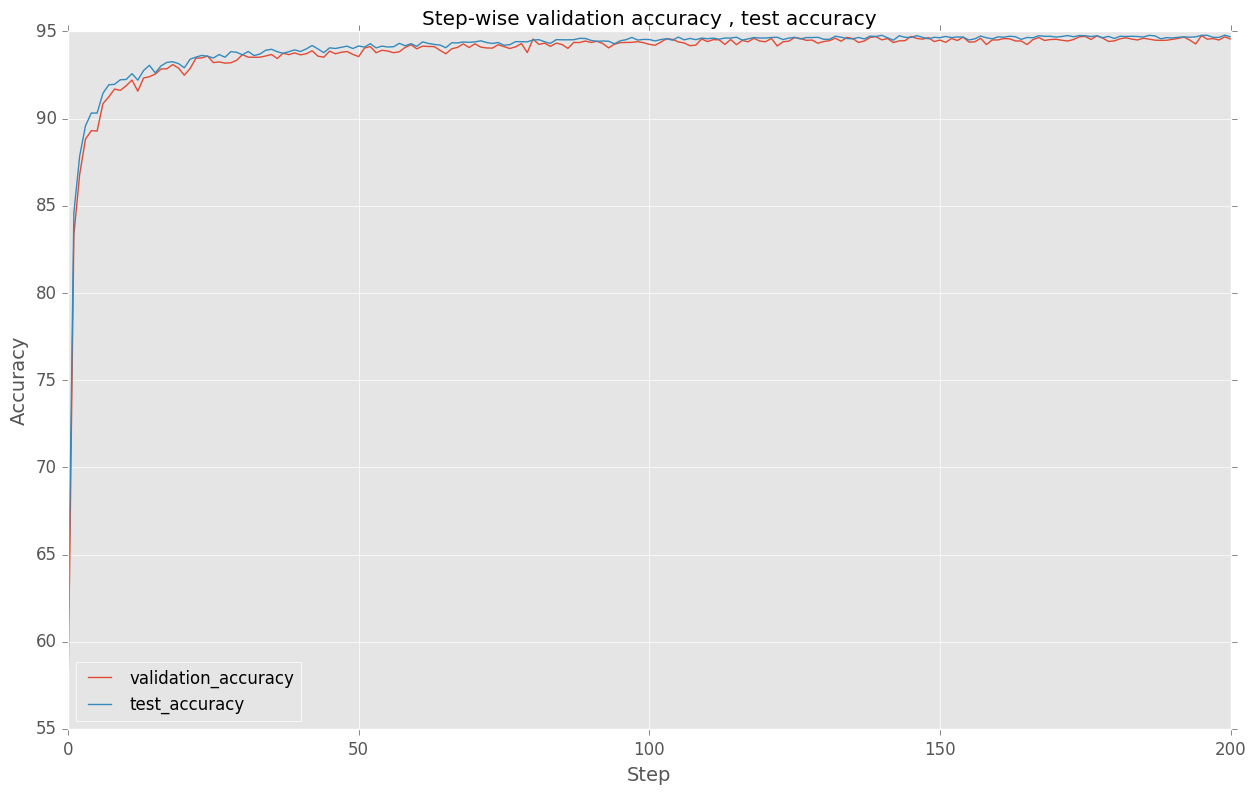

In [26]:
import numpy as np
#import renders as rs
from IPython.display import display 
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')
%matplotlib inline
print("(1) dropout probability : ","0.9375")
print("(2) bias variable(tf.constant value): ","0.0")
df_d1=pd.DataFrame(df_d,columns=["validation_accuracy","test_accuracy"])
ax = df_d1.plot(title="Step-wise validation accuracy , test accuracy",figsize=(15,9),legend=True, fontsize=12,stacked=False)
ax.set_xlabel("Step",fontsize=14)
ax.set_ylabel("Accuracy",fontsize=14)
plt.show()

(1) dropout probability :  0.9375
(2) bias variable(tf.constant value):  0.0


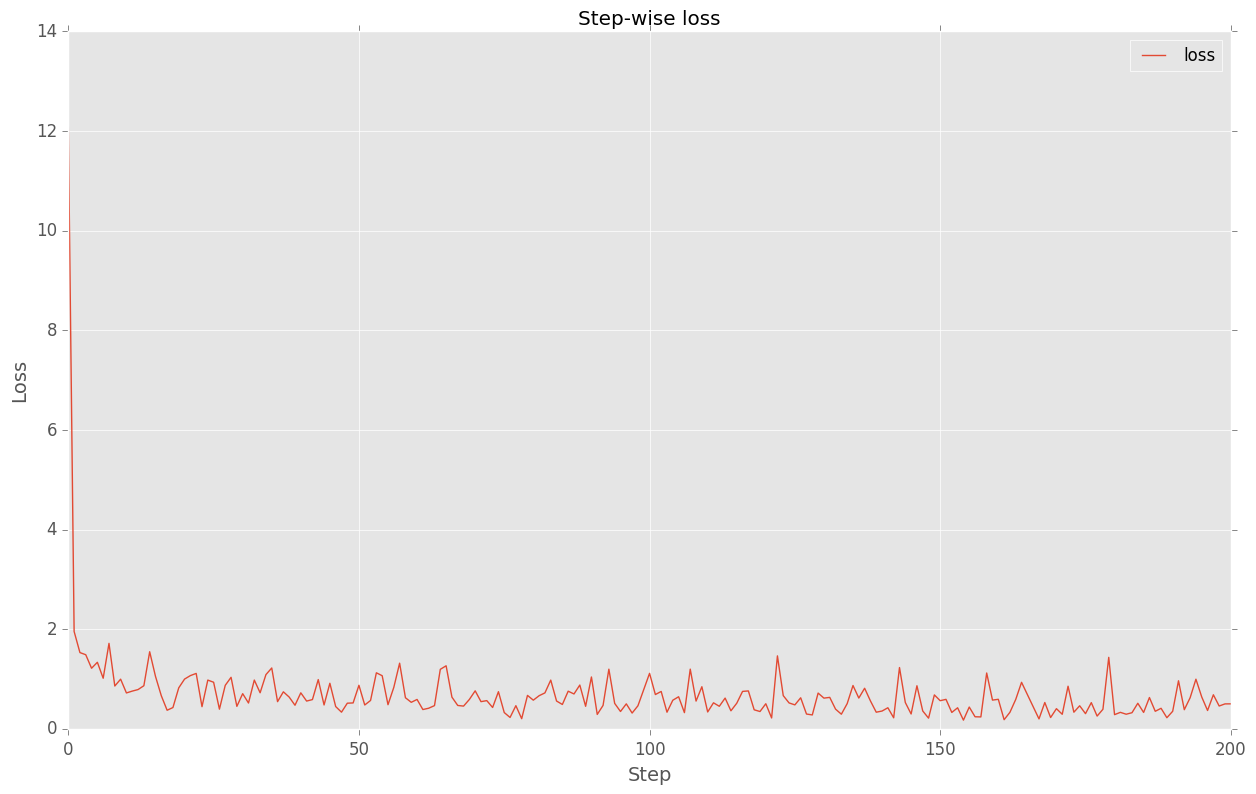

In [27]:
print("(1) dropout probability : ","0.9375")
print("(2) bias variable(tf.constant value): ","0.0")
df_d2=pd.DataFrame(df_d,columns=["loss"])
ax = df_d2.plot(title="Step-wise loss",figsize=(15,9),legend=True, fontsize=12,stacked=False)
ax.set_xlabel("Step",fontsize=14)
ax.set_ylabel("Loss",fontsize=14)
plt.show()

#### CONVOLUTION NEURAL NETWORK TEST 4_1 : (1) dropout probability : 1.0  (2) bias variable(tf.constant value): 0.0

In [8]:
#step-wise train. validation,test accuracy results are saved to forcsv4.csv file
with tf.device('/gpu:0'):
#with tf.device('/cpu:0'):    
    
            ##Variables.
   
    image_size = 32
    num_labels = 11 # blank, 0 ~ 9  
    num_channels = 1 # grayscale
    batch_size = 64
    patch_size = 5
    depth1 = 16
    depth2 = 32
    depth3 = 64
    num_hidden1 = 64
        #num_hidden2 = 16
    shape=[batch_size, image_size, image_size, num_channels]
        #keep_prob = 0.9375
        #keep_prob = 0.5
    
    
    
    graph = tf.Graph()
    with graph.as_default():


# Construct a 7-layer CNN.
# convolutional layer, batch_size x 28 x 28 x 16, convolution size: 5 x 5 x 1 x 16
# sub-sampling layer, batch_size x 14 x 14 x 16
# convolutional layer, batch_size x 10 x 10 x 32, convolution size: 5 x 5 x 16 x 32
# sub-sampling layer, batch_size x 5 x 5 x 32
# convolutional layer, batch_size x 1 x 1 x 64, convolution size: 5 x 5 x 32 x 64
# Dropout
# fully-connected layer, weight size: 64 x 16
# Output layer, weight size: 16 x 10   


        def weight_variable(shape):
            initial = tf.truncated_normal(shape, stddev=0.1) #stddev change to 0.01 from 0.1
            return tf.Variable(initial)
                        
        def bias_variable(shape):
            initial = tf.constant(0.0, shape=shape)
            #initial = tf.constant(1.0, shape=shape)
            return tf.Variable(initial)
        
        def conv2d(data, weight):
            #return tf.nn.conv2d(data, weight, strides=[1,1,1,1], padding='SAME')
            return tf.nn.conv2d(data, weight, strides=[1,1,1,1], padding='VALID')
                   
        def relu2d(initial, bias):
            return tf.nn.relu(initial + bias) 
        
        def max_pool_2x2(x):
            return tf.nn.max_pool(x, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')
        
        def reshape_flat(initial, shape):
            return tf.reshape(initial, [shape[0], shape[1] * shape[2] * shape[3]])
        
        
        def dropout2d(initial, keep_prob):
            return tf.nn.dropout(initial, keep_prob)
        
#         def softmax2d(initial, bias):
#             return tf.nn.softmax(initial + bias)
        print ("image_size:",image_size)    
        #input data for  the training data, We use placeholder that will be fed
        #at run time with a trainig minibatch                  
        #shape = (64,32,32,1)
        tf_train_dataset = tf.placeholder(tf.float32, shape =(batch_size, image_size, image_size, num_channels))
        #tf_train_labels = tf.placeholder(tf.float32, shape = (batch_size, num_labels))
        tf_train_labels = tf.placeholder(tf.int32, shape=(batch_size, 6))  #(64,6)
        #tf_train_labels = tf.placeholder(tf.int64, shape=(batch_size))
        #tf_valid_dataset = tf.constant(mnist.validation.images.reshape(-1, 28, 28, 1))
        tf_valid_dataset = tf.constant(valid_dataset)
        #tf_test_dataset = tf.constant(mnist.test.images.reshape(-1, 28, 28, 1))
        tf_test_dataset = tf.constant(test_dataset)

#         #                                     32]
        weight_conv1 = weight_variable([5,5,1,16]) #[patch_size, patch_size, num_channels, depth1]
        bias_conv1 = bias_variable([16])   # [depth1] USED BE 32
        weight_conv2 = weight_variable([5,5,16,32])  #[patch_size, patch_size, depth1, depth2] USED  BE 32,65]
        bias_conv2 = bias_variable([32]) #[depth2]  
        weight_conv3 = weight_variable([5,5,32,64])  #[patch_size, patch_size, depth2, num_hidden1]
        bias_conv3 = bias_variable([64]) #[num_hidden1]

        
        w1 = weight_variable([64,11]) #[num_hidden1, num_labels]
        b1 = bias_variable([11]) #[num_labels]
        w2 = weight_variable([64,11]) #[num_hidden1, num_labels]
        b2 = bias_variable([11]) #[num_labels]
        w3 = weight_variable([64,11]) #[num_hidden1, num_labels]
        b3 = bias_variable([11]) #[num_labels]
        w4 = weight_variable([64,11]) #[num_hidden1, num_labels]
        b4 = bias_variable([11]) #[num_labels]
        w5 = weight_variable([64,11]) #[num_hidden1, num_labels]
        b5 = bias_variable([11]) #[num_labels]
        
        #def model(data, keep_prob, shape):
        def model(data, keep_prob,shape):
            lcn = LecunLCN(data, shape)
            
#             print("lcn",lcn)
            conv = conv2d(lcn, weight_conv1)
#             print("conv:",conv)
            hidden = relu2d(conv, bias_conv1)
            lrn = tf.nn.local_response_normalization(hidden) # little  impact on perfomance: can be deleted.
            pool = max_pool_2x2(lrn)

#             print("pool1",pool)
            conv = conv2d(pool, weight_conv2)
#             print("conv2:",conv)
            hidden = relu2d(conv, bias_conv2)

#             print("hidden2:",hidden)
            pool = max_pool_2x2(hidden)
            #added conv layer (two lines)
            conv = conv2d(pool, weight_conv3)
#             print("conv3",conv)
            hidden = relu2d(conv, bias_conv3)
#             print("hidden3",hidden)
            ##added drop layer  
            drop = dropout2d(hidden,keep_prob)
#             print("drop:",drop)
            ## original asf ##
            #shape = hidden.get_shape().as_list() 
            shape = drop.get_shape().as_list() 
#             print("shape:",shape)
            #flat = reshape_flat(pool,shape)  # use when added conv layer is not deployed.  
            flat = reshape_flat(hidden,shape)
#             print("flat:",flat)
            
            logits1 = tf.matmul(flat, w1)+b1
            logits2 = tf.matmul(flat, w2)+b2
            logits3 = tf.matmul(flat, w3)+b3
            logits4 = tf.matmul(flat, w4)+b4
            logits5 = tf.matmul(flat, w5)+b5
            return [logits1, logits2, logits3, logits4, logits5]
        
 
       # Training computation.
        [logits1, logits2, logits3, logits4, logits5] = model(tf_train_dataset, 1.0, shape)
        #[logits1, logits2, logits3, logits4, logits5] = model(tf_train_dataset, 0.5, shape)
        loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits1, tf_train_labels[:,1])) +\
        tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits2, tf_train_labels[:,2])) +\
        tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits3, tf_train_labels[:,3])) +\
        tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits4, tf_train_labels[:,4])) +\
        tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits5, tf_train_labels[:,5]))
    
        # Optimizer.
        #optimizer = tf.train.AdagradOptimizer(0.01).minimize(loss)
        global_step = tf.Variable(0)
        learning_rate = tf.train.exponential_decay(0.05, global_step, 10000, 0.95)
        optimizer = tf.train.AdagradOptimizer(learning_rate).minimize(loss, global_step=global_step)
         
        # Predictions for training, validation, and test data.
        train_prediction = tf.pack([tf.nn.softmax(model(tf_train_dataset, 1.0, shape)[0]),\
                      tf.nn.softmax(model(tf_train_dataset, 1.0, shape)[1]),\
                      tf.nn.softmax(model(tf_train_dataset, 1.0, shape)[2]),\
                      tf.nn.softmax(model(tf_train_dataset, 1.0, shape)[3]),\
                      tf.nn.softmax(model(tf_train_dataset, 1.0, shape)[4])])
        valid_prediction = tf.pack([tf.nn.softmax(model(tf_valid_dataset, 1.0, shape)[0]),\
                      tf.nn.softmax(model(tf_valid_dataset, 1.0, shape)[1]),\
                      tf.nn.softmax(model(tf_valid_dataset, 1.0, shape)[2]),\
                      tf.nn.softmax(model(tf_valid_dataset, 1.0, shape)[3]),\
                      tf.nn.softmax(model(tf_valid_dataset, 1.0, shape)[4])])
        test_prediction = tf.pack([tf.nn.softmax(model(tf_test_dataset, 1.0, shape)[0]),\
                     tf.nn.softmax(model(tf_test_dataset, 1.0, shape)[1]),\
                     tf.nn.softmax(model(tf_test_dataset, 1.0, shape)[2]),\
                     tf.nn.softmax(model(tf_test_dataset, 1.0, shape)[3]),\
                     tf.nn.softmax(model(tf_test_dataset, 1.0, shape)[4])])
    
        saver = tf.train.Saver()

num_steps = 100001

with tf.Session(graph=graph) as session:
  tf.initialize_all_variables().run()  
  #read the trained CNN model from capstone_main_preprocess_project.ipynb
  reader = tf.train.NewCheckpointReader("/home/ys/tensorflow/tensorflow/examples/capstone_ex/CNN_1.ckpt")
  reader.get_variable_to_shape_map()
  #saver.restore(session, "CNN_1.ckpt")
  print("Model restored.")  

  print('Initialized')
  for step in range(num_steps):
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    batch_data = train_dataset[offset:(offset + batch_size), :, :, :]
    batch_labels = train_labels[offset:(offset + batch_size),:]
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    
    if (step % 500 == 0): 
        M_batch_accuracy = accuracy(predictions, batch_labels[:,1:6])
        Validation_accuracy = accuracy(valid_prediction.eval(), valid_labels[:,1:6])
        Test_accuracy = accuracy(test_prediction.eval(), test_labels[:,1:6])
        #save step, loss, accuracy into csv file.    
        result5 = "{},{},{},{},{}\n".format(step,l,M_batch_accuracy,Validation_accuracy,Test_accuracy)
        with open("forcsv7_drop.csv", "a") as myfile:
                myfile.write(result5)  
  print('Test accuracy: %.1f%%' % accuracy(test_prediction.eval(), test_labels[:,1:6]))
  save_path = saver.save(session, "CNN_multi_tune7_drop.ckpt")
  #save_path = saver.save(session, "/home/ys/tensorflow/tensorflow/examples/capston/CNN_multi.ckpt")  
  print("Model saved in file: %s" % save_path)

image_size: 32
Model restored.
Initialized
Test accuracy: 94.3%
Model saved in file: CNN_multi_tune7_drop.ckpt


In [15]:
#step-wise train. validation,test accuracy results are saved to forcsv7_drop.csv file
import pandas as pd
df_h = pd.read_csv("forcsv7_drop.csv",names = ["step","loss","minibatch_accuracy","validation_accuracy","test_accuracy"])
df_h.index.name='index_num'
print("(1) dropout probability : ","1.0")
print("(2) bias variable(tf.constant value): ","0.0")
df_h.head()

(1) dropout probability :  1.0
(2) bias variable(tf.constant value):  0.0


,step,loss,minibatch_accuracy,validation_accuracy,test_accuracy
index_num,,,,,
0,0,12.682892,3.1250,57.473610,64.064891
1,500,1.881890,89.0625,83.990148,85.489746
2,1000,1.553115,91.8750,86.544687,87.929293
3,1500,1.612102,90.9375,89.211823,89.811754
4,2000,1.031558,93.7500,90.024631,90.561677


In [16]:
df_h[196:201]

,step,loss,minibatch_accuracy,validation_accuracy,test_accuracy
index_num,,,,,
196,98000,0.320913,98.4375,94.496833,94.546985
197,98500,0.780671,96.2500,94.535538,94.419957
198,99000,0.517265,96.5625,94.419423,94.331191
199,99500,0.658386,96.5625,94.609430,94.566881
200,100000,0.489098,98.1250,94.440535,94.346495


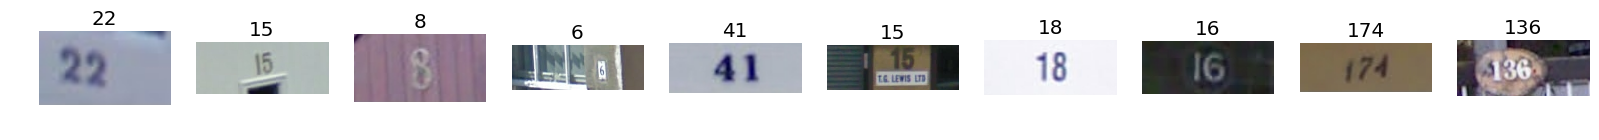

In [32]:
from PIL import Image
import os
import sys
import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams['figure.figsize'] = (20.0, 20.0)
f, ax = plt.subplots(nrows=1, ncols=10)

im_samples = []
    
for i, j in enumerate(np.sort(np.random.randint(0, test_labels.shape[0], size=10))):
    filename = str(j+1)+'.png'
    fullname = os.path.join('test', filename)
    im = Image.open(fullname)
    house_num = ''
    for k in np.arange(test_labels[j,0]):
        house_num += str(test_labels[j,k+1])
    im_samples.extend([j])
    ax[i].axis('off')
    ax[i].set_title(house_num, loc='center')
    ax[i].imshow(im)

In [33]:
#step-wise train. validation,test accuracy results are saved to forcsv.csv file
with tf.device('/gpu:0'):
#with tf.device('/cpu:0'):    
    
            ##Variables.
   
    image_size = 32
    num_labels = 11 # blank, 0 ~ 9  
    num_channels = 1 # grayscale
    batch_size = 64
    patch_size = 5
    depth1 = 16
    depth2 = 32
    depth3 = 64
    num_hidden1 = 64
        #num_hidden2 = 16
    shape=[batch_size, image_size, image_size, num_channels]
        #keep_prob = 0.9375
        #keep_prob = 0.5
    
    
    
    graph = tf.Graph()
    with graph.as_default():


# Construct a 7-layer CNN.
# convolutional layer, batch_size x 28 x 28 x 16, convolution size: 5 x 5 x 1 x 16
# sub-sampling layer, batch_size x 14 x 14 x 16
# convolutional layer, batch_size x 10 x 10 x 32, convolution size: 5 x 5 x 16 x 32
# sub-sampling layer, batch_size x 5 x 5 x 32
# convolutional layer, batch_size x 1 x 1 x 64, convolution size: 5 x 5 x 32 x 64
# Dropout
# fully-connected layer, weight size: 64 x 16
# Output layer, weight size: 16 x 10   

        
        def weight_variable(shape):
            initial = tf.truncated_normal(shape, stddev=0.1) #stddev change to 0.01 from 0.1
            return tf.Variable(initial)
                        
        def bias_variable(shape):
            initial = tf.constant(0.0, shape=shape)
            #initial = tf.constant(1.0, shape=shape)
            return tf.Variable(initial)
        
        def conv2d(data, weight):
            #return tf.nn.conv2d(data, weight, strides=[1,1,1,1], padding='SAME')
            return tf.nn.conv2d(data, weight, strides=[1,1,1,1], padding='VALID')
                   
        def relu2d(initial, bias):
            return tf.nn.relu(initial + bias) 
        
        def max_pool_2x2(x):
            return tf.nn.max_pool(x, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')
        
        def reshape_flat(initial, shape):
            return tf.reshape(initial, [shape[0], shape[1] * shape[2] * shape[3]])
        
        
        def dropout2d(initial, keep_prob):
            return tf.nn.dropout(initial, keep_prob)
        
#         def softmax2d(initial, bias):
#             return tf.nn.softmax(initial + bias)
#         print ("image_size:",image_size)    
#         #input data for  the training data, We use placeholder that will be fed
#         #at run time with a trainig minibatch                  
#         #shape = (64,32,32,1)
#         tf_train_dataset = tf.placeholder(tf.float32, shape =(batch_size, image_size, image_size, num_channels))
#         #tf_train_labels = tf.placeholder(tf.float32, shape = (batch_size, num_labels))
#         tf_train_labels = tf.placeholder(tf.int32, shape=(batch_size, 6))  #(64,6)
#         #tf_train_labels = tf.placeholder(tf.int64, shape=(batch_size))
#         #tf_valid_dataset = tf.constant(mnist.validation.images.reshape(-1, 28, 28, 1))
#         tf_valid_dataset = tf.constant(valid_dataset)
#         #tf_test_dataset = tf.constant(mnist.test.images.reshape(-1, 28, 28, 1))
#         tf_test_dataset = tf.constant(test_dataset)
#newly added for testing test_dataset         
        tf_test_dataset = tf.placeholder(tf.float32, shape=(10, 32, 32, 1))
#         #                                     32]
        weight_conv1 = weight_variable([5,5,1,16]) #[patch_size, patch_size, num_channels, depth1]
        bias_conv1 = bias_variable([16])   # [depth1] USED BE 32
        weight_conv2 = weight_variable([5,5,16,32])  #[patch_size, patch_size, depth1, depth2] USED  BE 32,65]
        bias_conv2 = bias_variable([32]) #[depth2]  
        weight_conv3 = weight_variable([5,5,32,64])  #[patch_size, patch_size, depth2, num_hidden1]
        bias_conv3 = bias_variable([64]) #[num_hidden1]

        
        w1 = weight_variable([64,11]) #[num_hidden1, num_labels]
        b1 = bias_variable([11]) #[num_labels]
        w2 = weight_variable([64,11]) #[num_hidden1, num_labels]
        b2 = bias_variable([11]) #[num_labels]
        w3 = weight_variable([64,11]) #[num_hidden1, num_labels]
        b3 = bias_variable([11]) #[num_labels]
        w4 = weight_variable([64,11]) #[num_hidden1, num_labels]
        b4 = bias_variable([11]) #[num_labels]
        w5 = weight_variable([64,11]) #[num_hidden1, num_labels]
        b5 = bias_variable([11]) #[num_labels]
        
        #def model(data, keep_prob, shape):
        def model(data, keep_prob,shape):
            lcn = LecunLCN(data, shape)
            
            print("lcn",lcn)
            conv = conv2d(lcn, weight_conv1)
            print("conv:",conv)
            hidden = relu2d(conv, bias_conv1)
            lrn = tf.nn.local_response_normalization(hidden) # little  impact on perfomance: can be deleted.
            pool = max_pool_2x2(lrn)
            
            print("pool1",pool)
            conv = conv2d(pool, weight_conv2)
            print("conv2:",conv)
            hidden = relu2d(conv, bias_conv2)

            print("hidden2:",hidden)
            pool = max_pool_2x2(hidden)
            #added conv layer (two lines)
            conv = conv2d(pool, weight_conv3)
            print("conv3",conv)
            hidden = relu2d(conv, bias_conv3)
            print("hidden3",hidden)
            ##added drop layer  
            drop = dropout2d(hidden,keep_prob)
            print("drop:",drop)
            ## original asf ##
            #shape = hidden.get_shape().as_list() 
            shape = drop.get_shape().as_list() 
            print("shape:",shape)
            #flat = reshape_flat(pool,shape)  # use when added conv layer is not deployed.  
            flat = reshape_flat(hidden,shape)
            print("flat:",flat)
            
            logits1 = tf.matmul(flat, w1)+b1
            logits2 = tf.matmul(flat, w2)+b2
            logits3 = tf.matmul(flat, w3)+b3
            logits4 = tf.matmul(flat, w4)+b4
            logits5 = tf.matmul(flat, w5)+b5
            return [logits1, logits2, logits3, logits4, logits5]
        
        
        # Training computation.
        [logits1, logits2, logits3, logits4, logits5] = model(tf_test_dataset, 1, [10, 32, 32, 1])

        predict = tf.pack([tf.nn.softmax(logits1),tf.nn.softmax(logits2),tf.nn.softmax(logits3),\
                         tf.nn.softmax(logits4),tf.nn.softmax(logits5)])
        test_prediction = tf.transpose(tf.argmax(predict, 2))
        saver = tf.train.Saver()

with tf.Session(graph=graph) as session:
  saver.restore(session, "/home/ys/tensorflow/tensorflow/examples/capstone_ex/CNN_multi_tune4.ckpt")  # invalid save path: 'CNN_multi2.ckpt'  error !!
  #saver.restore(session, "CNN_multi_tune3_2.ckpt")
  print("Model restored.")  

  print('Initialized')
  test_prediction = session.run(test_prediction, feed_dict={tf_test_dataset : test_dataset[im_samples,:,:,:],})
  print(test_prediction)
        


lcn Tensor("truediv:0", shape=(10, 32, 32, 1), dtype=float32)
conv: Tensor("Conv2D_2:0", shape=(10, 28, 28, 16), dtype=float32)
pool1 Tensor("MaxPool:0", shape=(10, 14, 14, 16), dtype=float32)
conv2: Tensor("Conv2D_3:0", shape=(10, 10, 10, 32), dtype=float32)
hidden2: Tensor("Relu_1:0", shape=(10, 10, 10, 32), dtype=float32)
conv3 Tensor("Conv2D_4:0", shape=(10, 1, 1, 64), dtype=float32)
hidden3 Tensor("Relu_2:0", shape=(10, 1, 1, 64), dtype=float32)
drop: Tensor("Relu_2:0", shape=(10, 1, 1, 64), dtype=float32)
shape: [10, 1, 1, 64]
flat: Tensor("Reshape:0", shape=(10, 64), dtype=float32)
Model restored.
Initialized
[[ 2  2 10 10 10]
 [ 1  5 10 10 10]
 [ 3 10 10 10 10]
 [ 1  6 10 10 10]
 [ 4  1 10 10 10]
 [ 1  5 10 10 10]
 [ 1  8 10 10 10]
 [ 1  6 10 10 10]
 [ 1  7  4 10 10]
 [ 1  3  6 10 10]]


### Number Image test result.

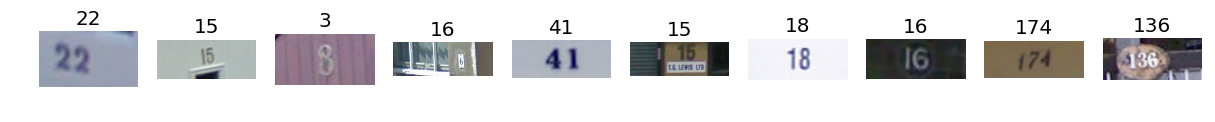

In [35]:
plt.rcParams['figure.figsize'] = (15.0, 15.0)
f, ax = plt.subplots(nrows=1, ncols=10)

for i, j in enumerate(im_samples):
    filename = str(j+1)+'.png'
    fullname = os.path.join('test', filename)
    im = Image.open(fullname)
    house_num = ''
    for k in np.arange(np.sum(test_prediction[i,:] != 10)):
        house_num += str(test_prediction[i,k])

    ax[i].axis('off')
    ax[i].set_title(house_num, loc='center')
    ax[i].imshow(im)